In [62]:
import csv
import os
from copy import deepcopy

import lightgbm as lgb
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import tensorflow as tf
from tqdm import tqdm

In [63]:
# Specify the data path and experiment name
current_path = "../data"
exp_type = "random_input"
test_exp_num = "exp-7"

In [64]:
parameters = {
    "exp": [f"exp-{i}" for i in range(1, 7)],
    # "exp": ["exp-7", "exp-8"],
    "target": "output_rate",  # output_rate / latency
    "dt": True,
    "trainer": "gbdt",
    "droplowcorr": False,
    "interpolate": False,
    "latencylog": False,
    "test": "../tmp/exp-9-10-dt.csv",  # False
    "valid": "../tmp/exp-7-8-dt.csv",  # False
}


In [65]:
def read_2headers(exp_type, exp_num, file):
    file_path = os.path.join(current_path, exp_type, exp_num, file)

    with open(file_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        headers_1 = next(reader)
        headers_2 = next(reader)
        headers = [i + " " + j for i, j in zip(headers_1, headers_2)]
    return headers, headers_1, headers_2

In [66]:
_, headers_1, headers_2 = read_2headers(exp_type, test_exp_num, "bridge-pcm.csv")

In [67]:
def get_sockets(headers_1):
    socket_num_set = set()
    for header in headers_1:
        if "Socket" in header:
            index_socket = header.find("Socket ")
            socket_num = header[index_socket + 7]
            socket_num_set.add(int(socket_num))
    return socket_num_set


def get_core_socket(headers_1):
    core_num_set = set()
    for header in headers_1:
        if "Core" in header:
            # pattern: Core7 (Socket 0)
            # we want 7 and 0
            index_core = header.find("Core")
            index_socket = header.find("Socket")
            if index_core == -1 or index_socket == -1:
                continue
            core_num = header[index_core + 4]
            socket_num = header[index_socket + 7]
            core_num_set.add((int(core_num), int(socket_num)))
    assert len(core_num_set) <= 1, str(core_num_set)
    if len(core_num_set) == 1:
        return list(core_num_set)[0]
    else:
        return None

In [68]:
print(get_sockets(headers_1))
print(get_core_socket(headers_1))

{0, 1}
(7, 0)


In [69]:
def remove_index_of_socket_core(headers_1, core_socket):
    if core_socket is None:
        return headers_1
    # deepcopy
    headers_1 = deepcopy(headers_1)
    for i in range(len(headers_1)):
        if "Socket" in headers_1[i] and "Core" in headers_1[i]:
            assert headers_1[i] == f"Core{core_socket[0]} (Socket {core_socket[1]})"
            headers_1[i] = f"Core (Socket)"
    return headers_1

In [70]:
headers_1_new = remove_index_of_socket_core(headers_1, get_core_socket(headers_1))
headers = [i + " " + j for i, j in zip(headers_1_new, headers_2)]
print(headers)

['System Date', 'System Time', 'Socket 0 EXEC', 'Socket 0 IPC', 'Socket 0 FREQ', 'Socket 0 AFREQ', 'Socket 0 L3MISS', 'Socket 0 L2MISS', 'Socket 0 L3HIT', 'Socket 0 L2HIT', 'Socket 0 L3MPI', 'Socket 0 L2MPI', 'Socket 0 L3OCC', 'Socket 0 READ', 'Socket 0 WRITE', 'Socket 0 LOCAL', 'Socket 0 TEMP', 'Socket 0 INST', 'Socket 0 ACYC', 'Socket 0 TIME(ticks)', 'Socket 0 PhysIPC', 'Socket 0 PhysIPC%', 'Socket 0 INSTnom', 'Socket 0 INSTnom%', 'Socket 1 EXEC', 'Socket 1 IPC', 'Socket 1 FREQ', 'Socket 1 AFREQ', 'Socket 1 L3MISS', 'Socket 1 L2MISS', 'Socket 1 L3HIT', 'Socket 1 L2HIT', 'Socket 1 L3MPI', 'Socket 1 L2MPI', 'Socket 1 L3OCC', 'Socket 1 READ', 'Socket 1 WRITE', 'Socket 1 LOCAL', 'Socket 1 TEMP', 'Socket 1 INST', 'Socket 1 ACYC', 'Socket 1 TIME(ticks)', 'Socket 1 PhysIPC', 'Socket 1 PhysIPC%', 'Socket 1 INSTnom', 'Socket 1 INSTnom%', 'SKT0 Core C-State C0res%', 'SKT0 Core C-State C1res%', 'SKT0 Core C-State C3res%', 'SKT0 Core C-State C6res%', 'SKT0 Core C-State C7res%', 'SKT0 Package C-S

In [71]:
def get_pcm_data_2headers(exp_type, exp_num, file):
    _, headers_1, headers_2 = read_2headers(exp_type, exp_num, file)
    headers_1_new = remove_index_of_socket_core(headers_1, get_core_socket(headers_1))
    headers = [i + " " + j for i, j in zip(headers_1_new, headers_2)]

    file_path = os.path.join(current_path, exp_type, exp_num, file)
    data = pd.read_csv(file_path, names=headers, skiprows=2, low_memory=False)
    # delete the columns if it's NaN
    # drop column with name " "
    data = data.drop([" "], axis=1, errors='ignore')
    data = data.dropna(axis=1, how='all')
    return data

In [72]:
get_pcm_data_2headers(exp_type, test_exp_num, "bridge-pcm.csv")

,System Date,System Time,Socket 0 EXEC,Socket 0 IPC,Socket 0 FREQ,Socket 0 AFREQ,Socket 0 L3MISS,Socket 0 L2MISS,Socket 0 L3HIT,Socket 0 L2HIT,...,Core (Socket) C6res%,Core (Socket) C7res%,Core (Socket) TEMP,Core (Socket) INST,Core (Socket) ACYC,Core (Socket) TIME(ticks),Core (Socket) PhysIPC,Core (Socket) PhysIPC%,Core (Socket) INSTnom,Core (Socket) INSTnom%
0,2024-02-26,12:13:13.936,0.17,2.75,0.06,1.12,0.09,12.83,0.99,0.27,...,0.0,0.0,49,1425.00,455.27,2599.04,6.26,156.50,1.10,27.41
1,2024-02-26,12:13:14.936,0.15,2.32,0.06,1.12,0.08,15.45,0.99,0.37,...,0.0,0.0,49,1125.87,405.15,2595.90,5.56,138.94,0.87,21.69
2,2024-02-26,12:13:15.936,0.15,2.40,0.06,1.12,0.08,15.83,1.00,0.37,...,0.0,0.0,49,1144.18,405.30,2598.07,5.65,141.15,0.88,22.02
3,2024-02-26,12:13:16.937,0.15,2.32,0.06,1.12,0.09,15.47,0.99,0.39,...,0.0,0.0,48,1101.78,401.08,2598.13,5.49,137.35,0.85,21.20
4,2024-02-26,12:13:17.936,0.15,2.35,0.06,1.12,0.07,15.62,1.00,0.39,...,0.0,0.0,47,1107.31,398.45,2595.52,5.56,138.95,0.85,21.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478,2024-02-26,12:37:52.137,0.16,2.60,0.06,1.12,0.05,18.68,1.00,0.34,...,0.0,0.0,36,1158.08,407.88,2598.10,5.68,141.96,0.89,22.29
1479,2024-02-26,12:37:53.136,0.17,2.57,0.07,1.12,0.03,18.73,1.00,0.38,...,0.0,0.0,36,1165.35,412.50,2595.53,5.65,141.25,0.90,22.45
1480,2024-02-26,12:37:54.136,0.16,2.58,0.06,1.12,0.07,18.44,1.00,0.34,...,0.0,0.0,36,1193.54,411.95,2595.47,5.79,144.86,0.92,22.99
1481,2024-02-26,12:37:55.136,0.15,2.61,0.06,1.12,0.03,18.37,1.00,0.28,...,0.0,0.0,36,1134.46,402.04,2598.54,5.64,141.09,0.87,21.83


In [73]:
get_pcm_data_2headers(exp_type, test_exp_num, "firewall-pcm.csv")

,System Date,System Time,Socket 0 EXEC,Socket 0 IPC,Socket 0 FREQ,Socket 0 AFREQ,Socket 0 L3MISS,Socket 0 L2MISS,Socket 0 L3HIT,Socket 0 L2HIT,...,Core (Socket) C6res%,Core (Socket) C7res%,Core (Socket) TEMP,Core (Socket) INST,Core (Socket) ACYC,Core (Socket) TIME(ticks),Core (Socket) PhysIPC,Core (Socket) PhysIPC%,Core (Socket) INSTnom,Core (Socket) INSTnom%
0,2024-02-26,12:13:12.768,1.10,3.37,0.33,1.12,0.14,9.63,0.99,0.83,...,0.0,0.0,45,7873.40,2114.41,2599.50,7.45,186.18,6.06,151.44
1,2024-02-26,12:13:13.769,0.21,2.93,0.07,1.12,0.09,10.85,0.99,0.30,...,0.0,0.0,46,1690.60,503.48,2597.42,6.72,167.89,1.30,32.54
2,2024-02-26,12:13:14.769,0.15,2.31,0.06,1.12,0.11,15.48,0.99,0.37,...,0.0,0.0,45,1173.38,406.39,2598.50,5.77,144.37,0.90,22.58
3,2024-02-26,12:13:15.769,0.15,2.39,0.06,1.12,0.07,15.84,1.00,0.36,...,0.0,0.0,45,1195.00,408.39,2598.08,5.85,146.31,0.92,23.00
4,2024-02-26,12:13:16.769,0.15,2.36,0.06,1.12,0.08,15.34,0.99,0.39,...,0.0,0.0,45,1145.00,392.95,2595.47,5.83,145.69,0.88,22.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1480,2024-02-26,12:37:52.961,0.17,2.57,0.06,1.12,0.04,18.68,1.00,0.37,...,0.0,0.0,34,1188.43,409.43,2594.92,5.81,145.13,0.92,22.90
1481,2024-02-26,12:37:53.962,0.16,2.51,0.06,1.12,0.09,18.08,0.99,0.36,...,0.0,0.0,33,1193.49,404.55,2599.86,5.90,147.51,0.92,22.95
1482,2024-02-26,12:37:54.961,0.16,2.63,0.06,1.12,0.05,18.86,1.00,0.29,...,0.0,0.0,34,1207.85,413.26,2595.11,5.85,146.14,0.93,23.27
1483,2024-02-26,12:37:55.961,0.16,2.61,0.06,1.12,0.03,18.88,1.00,0.29,...,0.0,0.0,33,1206.74,415.34,2597.40,5.81,145.27,0.93,23.23


In [74]:
get_pcm_data_2headers(exp_type, test_exp_num, "ndpi_stats-pcm.csv")

,System Date,System Time,Socket 0 EXEC,Socket 0 IPC,Socket 0 FREQ,Socket 0 AFREQ,Socket 0 L3MISS,Socket 0 L2MISS,Socket 0 L3HIT,Socket 0 L2HIT,...,Core (Socket) C6res%,Core (Socket) C7res%,Core (Socket) TEMP,Core (Socket) INST,Core (Socket) ACYC,Core (Socket) TIME(ticks),Core (Socket) PhysIPC,Core (Socket) PhysIPC%,Core (Socket) INSTnom,Core (Socket) INSTnom%
0,2024-02-26,12:13:13.404,0.34,3.27,0.10,1.12,0.10,7.30,0.99,0.53,...,0.0,0.0,46,2610.35,728.88,2599.41,7.16,179.07,2.01,50.21
1,2024-02-26,12:13:14.405,0.14,2.42,0.06,1.12,0.09,15.15,0.99,0.31,...,0.0,0.0,47,1051.98,396.62,2598.77,5.30,132.62,0.81,20.24
2,2024-02-26,12:13:15.404,0.15,2.35,0.06,1.12,0.08,15.52,0.99,0.36,...,0.0,0.0,47,1059.33,402.58,2595.35,5.26,131.57,0.82,20.41
3,2024-02-26,12:13:16.405,0.15,2.39,0.06,1.12,0.09,15.86,0.99,0.39,...,0.0,0.0,47,1087.14,402.77,2598.04,5.40,134.96,0.84,20.92
4,2024-02-26,12:13:17.405,0.15,2.32,0.06,1.12,0.07,15.39,1.00,0.39,...,0.0,0.0,46,1036.68,390.57,2598.20,5.31,132.71,0.80,19.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479,2024-02-26,12:37:52.588,0.16,2.62,0.06,1.12,0.03,18.65,1.00,0.34,...,0.0,0.0,35,1206.94,405.03,2597.19,5.96,149.00,0.93,23.24
1480,2024-02-26,12:37:53.588,0.16,2.46,0.07,1.12,0.10,18.15,0.99,0.39,...,0.0,0.0,35,1186.12,403.63,2597.27,5.88,146.93,0.91,22.83
1481,2024-02-26,12:37:54.589,0.17,2.68,0.06,1.12,0.03,19.01,1.00,0.32,...,0.0,0.0,35,1237.59,411.18,2597.53,6.02,150.49,0.95,23.82
1482,2024-02-26,12:37:55.589,0.16,2.59,0.06,1.12,0.04,18.72,1.00,0.26,...,0.0,0.0,36,1210.34,411.83,2597.31,5.88,146.95,0.93,23.30


In [75]:
get_pcm_data_2headers(exp_type, test_exp_num, "nf_router-pcm.csv")

,System Date,System Time,Socket 0 EXEC,Socket 0 IPC,Socket 0 FREQ,Socket 0 AFREQ,Socket 0 L3MISS,Socket 0 L2MISS,Socket 0 L3HIT,Socket 0 L2HIT,...,Core (Socket) C6res%,Core (Socket) C7res%,Core (Socket) TEMP,Core (Socket) INST,Core (Socket) ACYC,Core (Socket) TIME(ticks),Core (Socket) PhysIPC,Core (Socket) PhysIPC%,Core (Socket) INSTnom,Core (Socket) INSTnom%
0,2024-02-26,12:13:13.504,0.30,3.34,0.09,1.12,0.08,6.66,0.99,0.51,...,0.0,0.0,45,2336.40,646.17,2599.39,7.23,180.79,1.80,44.94
1,2024-02-26,12:13:14.505,0.15,2.35,0.06,1.12,0.09,15.37,0.99,0.33,...,0.0,0.0,45,1194.22,414.67,2598.67,5.76,144.00,0.92,22.98
2,2024-02-26,12:13:15.505,0.15,2.37,0.06,1.12,0.09,15.75,0.99,0.35,...,0.0,0.0,45,1226.81,415.52,2598.06,5.90,147.62,0.94,23.61
3,2024-02-26,12:13:16.505,0.15,2.37,0.06,1.12,0.08,15.42,0.99,0.40,...,0.0,0.0,45,1190.93,403.47,2595.62,5.90,147.59,0.92,22.94
4,2024-02-26,12:13:17.505,0.15,2.35,0.06,1.12,0.08,15.90,1.00,0.39,...,0.0,0.0,45,1220.11,416.41,2598.07,5.86,146.50,0.94,23.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479,2024-02-26,12:37:52.704,0.16,2.58,0.06,1.12,0.04,18.84,1.00,0.34,...,0.0,0.0,33,1278.53,415.79,2597.03,6.15,153.75,0.98,24.61
1480,2024-02-26,12:37:53.704,0.16,2.50,0.07,1.12,0.10,18.36,0.99,0.38,...,0.0,0.0,34,1270.75,410.99,2597.17,6.18,154.60,0.98,24.46
1481,2024-02-26,12:37:54.704,0.16,2.64,0.06,1.12,0.03,18.68,1.00,0.30,...,0.0,0.0,34,1273.35,409.35,2597.47,6.22,155.54,0.98,24.51
1482,2024-02-26,12:37:55.704,0.16,2.62,0.06,1.12,0.03,18.85,1.00,0.28,...,0.0,0.0,34,1287.34,415.93,2597.21,6.19,154.75,0.99,24.78


In [76]:
get_pcm_data_2headers(exp_type, test_exp_num, "payload_scan-pcm.csv")

,System Date,System Time,Socket 0 EXEC,Socket 0 IPC,Socket 0 FREQ,Socket 0 AFREQ,Socket 0 L3MISS,Socket 0 L2MISS,Socket 0 L3HIT,Socket 0 L2HIT,...,Core (Socket) C6res%,Core (Socket) C7res%,Core (Socket) TEMP,Core (Socket) INST,Core (Socket) ACYC,Core (Socket) TIME(ticks),Core (Socket) PhysIPC,Core (Socket) PhysIPC%,Core (Socket) INSTnom,Core (Socket) INSTnom%
0,2024-02-26,12:13:13.793,0.21,2.99,0.07,1.12,0.08,10.26,0.99,0.30,...,0.0,0.0,46,1650.17,503.29,2602.73,6.56,163.94,1.27,31.70
1,2024-02-26,12:13:14.793,0.14,2.32,0.06,1.12,0.08,15.04,0.99,0.38,...,0.0,0.0,46,1080.03,394.15,2592.26,5.48,137.01,0.83,20.83
2,2024-02-26,12:13:15.793,0.15,2.41,0.06,1.12,0.07,15.92,1.00,0.35,...,0.0,0.0,46,1132.69,405.40,2601.26,5.59,139.70,0.87,21.77
3,2024-02-26,12:13:16.793,0.15,2.33,0.06,1.12,0.09,15.74,0.99,0.39,...,0.0,0.0,47,1113.67,404.43,2597.69,5.51,137.68,0.86,21.44
4,2024-02-26,12:13:17.793,0.15,2.34,0.06,1.12,0.08,15.76,0.99,0.39,...,0.0,0.0,46,1113.63,403.55,2597.67,5.52,137.98,0.86,21.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479,2024-02-26,12:37:52.978,0.17,2.57,0.06,1.12,0.03,18.91,1.00,0.37,...,0.0,0.0,35,1220.22,412.06,2597.03,5.92,148.07,0.94,23.49
1480,2024-02-26,12:37:53.978,0.16,2.55,0.06,1.12,0.09,17.95,0.99,0.36,...,0.0,0.0,35,1194.32,399.06,2597.21,5.99,149.64,0.92,22.99
1481,2024-02-26,12:37:54.978,0.16,2.61,0.06,1.12,0.04,18.79,1.00,0.29,...,0.0,0.0,34,1217.94,412.11,2597.31,5.91,147.77,0.94,23.45
1482,2024-02-26,12:37:55.978,0.16,2.64,0.06,1.12,0.04,19.04,1.00,0.30,...,0.0,0.0,34,1234.60,412.07,2597.05,5.99,149.80,0.95,23.77


In [77]:
get_pcm_data_2headers(exp_type, test_exp_num, "rx-pcm.csv")

,System Date,System Time,Socket 0 EXEC,Socket 0 IPC,Socket 0 FREQ,Socket 0 AFREQ,Socket 0 L3MISS,Socket 0 L2MISS,Socket 0 L3HIT,Socket 0 L2HIT,...,Core (Socket) C6res%,Core (Socket) C7res%,Core (Socket) TEMP,Core (Socket) INST,Core (Socket) ACYC,Core (Socket) TIME(ticks),Core (Socket) PhysIPC,Core (Socket) PhysIPC%,Core (Socket) INSTnom,Core (Socket) INSTnom%
0,2024-02-26,12:13:14.333,0.14,2.35,0.06,1.12,0.09,15.14,0.99,0.30,...,0.0,0.0,48,547.93,396.54,2599.91,2.76,69.09,0.42,10.54
1,2024-02-26,12:13:15.332,0.15,2.35,0.06,1.12,0.08,15.51,0.99,0.35,...,0.0,0.0,48,560.72,400.92,2595.43,2.80,69.93,0.43,10.80
2,2024-02-26,12:13:16.332,0.15,2.40,0.06,1.12,0.09,15.71,0.99,0.40,...,0.0,0.0,48,570.94,396.94,2597.57,2.88,71.92,0.44,10.99
3,2024-02-26,12:13:17.332,0.14,2.32,0.06,1.12,0.09,15.27,0.99,0.39,...,0.0,0.0,47,549.12,388.07,2597.65,2.83,70.75,0.42,10.57
4,2024-02-26,12:13:18.332,0.15,2.41,0.06,1.12,0.09,15.92,0.99,0.39,...,0.0,0.0,46,574.27,398.74,2597.26,2.88,72.01,0.44,11.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478,2024-02-26,12:37:52.526,0.16,2.56,0.06,1.12,0.05,18.85,1.00,0.34,...,0.0,0.0,35,787.66,410.57,2596.99,3.84,95.92,0.61,15.16
1479,2024-02-26,12:37:53.526,0.17,2.51,0.07,1.12,0.10,18.50,0.99,0.38,...,0.0,0.0,35,762.14,408.62,2597.44,3.73,93.26,0.59,14.67
1480,2024-02-26,12:37:54.526,0.16,2.62,0.06,1.12,0.04,18.30,1.00,0.33,...,0.0,0.0,35,766.68,400.39,2598.02,3.83,95.74,0.59,14.76
1481,2024-02-26,12:37:55.526,0.16,2.63,0.06,1.12,0.03,18.82,1.00,0.24,...,0.0,0.0,35,789.46,413.27,2596.93,3.82,95.51,0.61,15.20


In [78]:
get_pcm_data_2headers(exp_type, test_exp_num, "tx-pcm.csv")

,System Date,System Time,Socket 0 EXEC,Socket 0 IPC,Socket 0 FREQ,Socket 0 AFREQ,Socket 0 L3MISS,Socket 0 L2MISS,Socket 0 L3HIT,Socket 0 L2HIT,...,Core (Socket) C6res%,Core (Socket) C7res%,Core (Socket) TEMP,Core (Socket) INST,Core (Socket) ACYC,Core (Socket) TIME(ticks),Core (Socket) PhysIPC,Core (Socket) PhysIPC%,Core (Socket) INSTnom,Core (Socket) INSTnom%
0,2024-02-26,12:13:14.309,0.14,2.44,0.06,1.12,0.08,15.09,0.99,0.29,...,0.0,0.0,43,934.12,400.51,2599.79,4.66,116.62,0.72,17.96
1,2024-02-26,12:13:15.309,0.15,2.36,0.06,1.12,0.08,15.52,0.99,0.35,...,0.0,0.0,43,932.79,404.47,2596.04,4.61,115.31,0.72,17.97
2,2024-02-26,12:13:16.309,0.15,2.40,0.06,1.12,0.08,15.83,1.00,0.39,...,0.0,0.0,44,952.75,405.81,2597.98,4.70,117.39,0.73,18.34
3,2024-02-26,12:13:17.310,0.15,2.33,0.06,1.12,0.09,15.27,0.99,0.40,...,0.0,0.0,42,909.76,394.91,2598.52,4.61,115.19,0.70,17.51
4,2024-02-26,12:13:18.309,0.15,2.31,0.06,1.12,0.08,15.78,0.99,0.39,...,0.0,0.0,43,926.02,407.42,2595.58,4.55,113.64,0.71,17.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478,2024-02-26,12:37:52.499,0.16,2.67,0.06,1.12,0.03,18.94,1.00,0.34,...,0.0,0.0,30,1068.99,411.46,2597.12,5.20,129.90,0.82,20.58
1479,2024-02-26,12:37:53.499,0.16,2.42,0.07,1.12,0.10,17.92,0.99,0.39,...,0.0,0.0,31,994.87,400.83,2597.18,4.96,124.10,0.77,19.15
1480,2024-02-26,12:37:54.499,0.16,2.66,0.06,1.12,0.03,18.72,1.00,0.34,...,0.0,0.0,32,1075.99,411.96,2597.80,5.22,130.59,0.83,20.71
1481,2024-02-26,12:37:55.499,0.16,2.63,0.06,1.12,0.04,18.84,1.00,0.24,...,0.0,0.0,31,1057.07,412.95,2597.46,5.12,127.99,0.81,20.35


In [79]:
def get_pcm_data_memory(exp_type, exp_num, file):
    _, headers_1, headers_2 = read_2headers(exp_type, exp_num, file)
    headers_1[0] = "System"
    headers_1[1] = "System"
    headers = [i + " " + j for i, j in zip(headers_1, headers_2)]

    assert "memory" in file

    file_path = os.path.join(current_path, exp_type, exp_num, file)
    data = pd.read_csv(file_path, names=headers, skiprows=2)
    # delete the columns if it's NaN
    data = data.dropna(axis=1, how='all')
    return data

In [80]:
get_pcm_data_memory(exp_type, test_exp_num, "pcm-memory.csv")

,System Date,System Time,SKT0 Ch0Read,SKT0 Ch0Write,SKT0 Ch1Read,SKT0 Ch1Write,SKT0 Mem Read (MB/s),SKT0 Mem Write (MB/s),SKT0 P. Write (T/s),SKT0 Memory (MB/s),...,SKT1 Ch0Write,SKT1 Ch1Read,SKT1 Ch1Write,SKT1 Mem Read (MB/s),SKT1 Mem Write (MB/s),SKT1 P. Write (T/s),SKT1 Memory (MB/s),System Read,System Write,System Memory
0,2024-02-26,12:13:14.251,148.94,207.59,543.79,403.84,692.73,611.43,2012765306,1304.16,...,8.87,217.83,5.66,437.66,14.54,2012999134,452.20,1130.39,625.97,1756.36
1,2024-02-26,12:13:15.251,153.33,212.78,563.77,417.56,717.11,630.35,2133370598,1347.45,...,6.83,217.89,3.40,437.76,10.23,2133483506,448.00,1154.87,640.58,1795.45
2,2024-02-26,12:13:16.251,151.62,209.93,559.26,413.68,710.88,623.62,2133103792,1334.49,...,6.71,215.18,3.26,432.96,9.97,2132962705,442.93,1143.84,633.58,1777.42
3,2024-02-26,12:13:17.251,149.99,206.26,554.59,408.73,704.58,614.99,2133069675,1319.57,...,5.60,208.51,2.16,419.94,7.76,2133134684,427.70,1124.52,622.75,1747.27
4,2024-02-26,12:13:18.251,148.97,205.01,550.76,406.23,699.73,611.24,2132932266,1310.97,...,6.64,208.07,3.21,418.69,9.85,2132809241,428.54,1118.42,621.09,1739.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478,2024-02-26,12:37:52.446,74.90,150.58,267.02,253.25,341.92,403.83,2132420003,745.74,...,5.21,182.07,1.83,367.06,7.04,2132475102,374.10,708.97,410.87,1119.85
1479,2024-02-26,12:37:53.446,84.39,162.86,297.82,276.33,382.21,439.19,2132642497,821.40,...,17.74,205.35,14.33,413.11,32.06,2132734473,445.18,795.32,471.25,1266.57
1480,2024-02-26,12:37:54.447,80.34,162.15,284.61,271.44,364.95,433.59,2134862016,798.54,...,8.89,204.62,5.45,412.32,14.34,2134805364,426.65,777.27,447.93,1225.20
1481,2024-02-26,12:37:55.447,75.01,151.83,266.82,254.68,341.84,406.51,2132497060,748.34,...,5.57,190.93,2.18,384.04,7.75,2132438267,391.79,725.87,414.26,1140.13


In [81]:
def get_pcm_data_pcie(exp_type, exp_num, file):
    assert "pcie" in file
    with open(os.path.join(current_path, exp_type, exp_num, file), newline='') as f:
        line_index = -1
        headers_mid = "PCIRdCur,RFO,CRd,DRd,ItoM,PRd,WiL".split(",")
        headers_prefix = [f"Skt{i}_" for i in range(2)]
        headers_suffix = ["_Total", "_Miss", "_Hit"]
        headers = [i + j for j in headers_suffix for i in headers_mid]
        headers = [i + j for i in headers_prefix for j in headers]
        f_lines = f.readlines()
        data_len = len(f_lines) / 7
        assert data_len.is_integer()
        data_len = int(data_len)
        data = np.zeros((data_len, len(headers)))
        for header in headers:
            print(header)
        for line in f_lines:
            if not line[0].isdigit():
                line_index += 1
                # if line_index != 0:
                #     print(data[line_index-1])
                continue
            index_start = 0
            if line.strip().endswith("l)"):
                pass
            elif line.strip().endswith("s)"):
                index_start += 7
            elif line.strip().endswith("t)"):
                index_start += 14
            index_start += 21 * int(line.split(",", 1)[0])
            data[line_index, index_start:index_start + 7] = list(map(float, line[:line.rfind("(")].split(",")[1:]))
        data = pd.DataFrame(data, columns=headers)
        return data

In [82]:
get_pcm_data_pcie(exp_type, test_exp_num, "pcm-pcie.csv")

Skt0_PCIRdCur_Total
Skt0_RFO_Total
Skt0_CRd_Total
Skt0_DRd_Total
Skt0_ItoM_Total
Skt0_PRd_Total
Skt0_WiL_Total
Skt0_PCIRdCur_Miss
Skt0_RFO_Miss
Skt0_CRd_Miss
Skt0_DRd_Miss
Skt0_ItoM_Miss
Skt0_PRd_Miss
Skt0_WiL_Miss
Skt0_PCIRdCur_Hit
Skt0_RFO_Hit
Skt0_CRd_Hit
Skt0_DRd_Hit
Skt0_ItoM_Hit
Skt0_PRd_Hit
Skt0_WiL_Hit
Skt1_PCIRdCur_Total
Skt1_RFO_Total
Skt1_CRd_Total
Skt1_DRd_Total
Skt1_ItoM_Total
Skt1_PRd_Total
Skt1_WiL_Total
Skt1_PCIRdCur_Miss
Skt1_RFO_Miss
Skt1_CRd_Miss
Skt1_DRd_Miss
Skt1_ItoM_Miss
Skt1_PRd_Miss
Skt1_WiL_Miss
Skt1_PCIRdCur_Hit
Skt1_RFO_Hit
Skt1_CRd_Hit
Skt1_DRd_Hit
Skt1_ItoM_Hit
Skt1_PRd_Hit
Skt1_WiL_Hit


,Skt0_PCIRdCur_Total,Skt0_RFO_Total,Skt0_CRd_Total,Skt0_DRd_Total,Skt0_ItoM_Total,Skt0_PRd_Total,Skt0_WiL_Total,Skt0_PCIRdCur_Miss,Skt0_RFO_Miss,Skt0_CRd_Miss,...,Skt1_ItoM_Miss,Skt1_PRd_Miss,Skt1_WiL_Miss,Skt1_PCIRdCur_Hit,Skt1_RFO_Hit,Skt1_CRd_Hit,Skt1_DRd_Hit,Skt1_ItoM_Hit,Skt1_PRd_Hit,Skt1_WiL_Hit
0,11337816.0,2685144.0,4515182.0,94503010.0,8244600.0,0.0,410942.0,2.085217e+09,1479744.0,13790.0,...,0.0,27650.0,164094.0,0.0,124670.0,5362308.0,10137708.0,0.0,406.0,1274.0
1,11310124.0,2865380.0,2445506.0,97077638.0,8298990.0,0.0,423934.0,1.216600e+04,1371482.0,15568.0,...,0.0,27748.0,165382.0,4111492.0,124810.0,5653620.0,10368372.0,0.0,448.0,0.0
2,11400200.0,2929192.0,1698298.0,97537272.0,8289974.0,0.0,418572.0,9.758000e+03,1296316.0,18256.0,...,0.0,27958.0,164934.0,4244184.0,125874.0,4620644.0,10495408.0,0.0,168.0,406.0
3,11435886.0,2982812.0,1690794.0,101253852.0,8314600.0,0.0,422674.0,7.028000e+03,1240624.0,29498.0,...,0.0,27902.0,163436.0,4347420.0,125230.0,4377590.0,10138548.0,0.0,42.0,0.0
4,11474078.0,3026310.0,1687364.0,101093342.0,8301188.0,0.0,432418.0,5.768000e+03,1182748.0,19418.0,...,0.0,27762.0,164458.0,4424644.0,124894.0,4433772.0,10256232.0,0.0,378.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,10678080.0,3417624.0,1717996.0,124989620.0,7055734.0,0.0,697956.0,3.360000e+02,659680.0,65324.0,...,0.0,24248.0,142254.0,3807748.0,107968.0,4445756.0,9588600.0,0.0,84.0,1078.0
1468,10689126.0,3439184.0,1589546.0,125107738.0,7117558.0,0.0,675458.0,3.220000e+02,654990.0,12642.0,...,0.0,24108.0,141918.0,3875158.0,109284.0,4358984.0,9433928.0,0.0,126.0,1442.0
1469,10628128.0,3408482.0,2241484.0,125399022.0,7055426.0,112.0,686826.0,1.120000e+03,755930.0,51982.0,...,0.0,24304.0,143920.0,3232194.0,108948.0,5298706.0,9652930.0,0.0,0.0,0.0
1470,10669400.0,3433892.0,2218888.0,126031598.0,7054474.0,140.0,684656.0,3.220000e+02,718718.0,18634.0,...,0.0,24080.0,143094.0,3535644.0,109452.0,4827228.0,9365496.0,0.0,210.0,0.0


In [83]:
# Data with timestamps:
# bridge-pcm.csv
# firewall-pcm.csv
# ndpi_stats-pcm.csv
# nf_router-pcm.csv
# payload_scan-pcm.csv
# rx-pcm.csv
# tx-pcm.csv

In [84]:
import datetime


def data_time_interpolate(data, interpolate=parameters["interpolate"]):
    def round_to_nearest_second(x: str) -> str:
        t = datetime.datetime.strptime(x, "%H:%M:%S.%f")
        if t.microsecond >= 500000:
            t += datetime.timedelta(seconds=1)
        t = t.replace(microsecond=0)
        t_str = t.strftime("%H:%M:%S")
        return t_str

    if interpolate:
        # Take the last 3 digit of "System Time" as the microsecond, and convert it to int
        data["time_ms"] = data["System Time"].apply(
            lambda x: int(x[:2]) * 60 * 60 * 1000 + int(x[3:5]) * 60 * 1000 + int(x[6:8]) * 1000 + int(x[9:]))

        data_new = (
                data.iloc[:-1, 2:-1].multiply(data["time_ms"].shift(-1).iloc[:-1] % 1000, axis=0) +
                data.shift(-1).iloc[:-1, 2:-1].multiply(1000 - data["time_ms"].shift(-1).iloc[:-1] % 1000, axis=0)
        ).divide(
            (data["time_ms"].shift(-1).iloc[:-1] % 1000 + 1000 - data["time_ms"].iloc[:-1] % 1000), axis=0
        )

        data = data.shift(-1).iloc[:-1, :2].join(data_new)

        data["System Time"] = data["System Time"].apply(lambda x: str(x)[:-3] + "000")
        return data
    else:
        # round to the nearest second
        data["System Time"] = data["System Time"].apply(lambda x: round_to_nearest_second(x))
        return data

In [85]:
get_pcm_data_2headers(exp_type, test_exp_num, "bridge-pcm.csv")

,System Date,System Time,Socket 0 EXEC,Socket 0 IPC,Socket 0 FREQ,Socket 0 AFREQ,Socket 0 L3MISS,Socket 0 L2MISS,Socket 0 L3HIT,Socket 0 L2HIT,...,Core (Socket) C6res%,Core (Socket) C7res%,Core (Socket) TEMP,Core (Socket) INST,Core (Socket) ACYC,Core (Socket) TIME(ticks),Core (Socket) PhysIPC,Core (Socket) PhysIPC%,Core (Socket) INSTnom,Core (Socket) INSTnom%
0,2024-02-26,12:13:13.936,0.17,2.75,0.06,1.12,0.09,12.83,0.99,0.27,...,0.0,0.0,49,1425.00,455.27,2599.04,6.26,156.50,1.10,27.41
1,2024-02-26,12:13:14.936,0.15,2.32,0.06,1.12,0.08,15.45,0.99,0.37,...,0.0,0.0,49,1125.87,405.15,2595.90,5.56,138.94,0.87,21.69
2,2024-02-26,12:13:15.936,0.15,2.40,0.06,1.12,0.08,15.83,1.00,0.37,...,0.0,0.0,49,1144.18,405.30,2598.07,5.65,141.15,0.88,22.02
3,2024-02-26,12:13:16.937,0.15,2.32,0.06,1.12,0.09,15.47,0.99,0.39,...,0.0,0.0,48,1101.78,401.08,2598.13,5.49,137.35,0.85,21.20
4,2024-02-26,12:13:17.936,0.15,2.35,0.06,1.12,0.07,15.62,1.00,0.39,...,0.0,0.0,47,1107.31,398.45,2595.52,5.56,138.95,0.85,21.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478,2024-02-26,12:37:52.137,0.16,2.60,0.06,1.12,0.05,18.68,1.00,0.34,...,0.0,0.0,36,1158.08,407.88,2598.10,5.68,141.96,0.89,22.29
1479,2024-02-26,12:37:53.136,0.17,2.57,0.07,1.12,0.03,18.73,1.00,0.38,...,0.0,0.0,36,1165.35,412.50,2595.53,5.65,141.25,0.90,22.45
1480,2024-02-26,12:37:54.136,0.16,2.58,0.06,1.12,0.07,18.44,1.00,0.34,...,0.0,0.0,36,1193.54,411.95,2595.47,5.79,144.86,0.92,22.99
1481,2024-02-26,12:37:55.136,0.15,2.61,0.06,1.12,0.03,18.37,1.00,0.28,...,0.0,0.0,36,1134.46,402.04,2598.54,5.64,141.09,0.87,21.83


In [86]:
data_time_interpolate(get_pcm_data_2headers(exp_type, test_exp_num, "bridge-pcm.csv"))

,System Date,System Time,Socket 0 EXEC,Socket 0 IPC,Socket 0 FREQ,Socket 0 AFREQ,Socket 0 L3MISS,Socket 0 L2MISS,Socket 0 L3HIT,Socket 0 L2HIT,...,Core (Socket) C6res%,Core (Socket) C7res%,Core (Socket) TEMP,Core (Socket) INST,Core (Socket) ACYC,Core (Socket) TIME(ticks),Core (Socket) PhysIPC,Core (Socket) PhysIPC%,Core (Socket) INSTnom,Core (Socket) INSTnom%
0,2024-02-26,12:13:14,0.17,2.75,0.06,1.12,0.09,12.83,0.99,0.27,...,0.0,0.0,49,1425.00,455.27,2599.04,6.26,156.50,1.10,27.41
1,2024-02-26,12:13:15,0.15,2.32,0.06,1.12,0.08,15.45,0.99,0.37,...,0.0,0.0,49,1125.87,405.15,2595.90,5.56,138.94,0.87,21.69
2,2024-02-26,12:13:16,0.15,2.40,0.06,1.12,0.08,15.83,1.00,0.37,...,0.0,0.0,49,1144.18,405.30,2598.07,5.65,141.15,0.88,22.02
3,2024-02-26,12:13:17,0.15,2.32,0.06,1.12,0.09,15.47,0.99,0.39,...,0.0,0.0,48,1101.78,401.08,2598.13,5.49,137.35,0.85,21.20
4,2024-02-26,12:13:18,0.15,2.35,0.06,1.12,0.07,15.62,1.00,0.39,...,0.0,0.0,47,1107.31,398.45,2595.52,5.56,138.95,0.85,21.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478,2024-02-26,12:37:52,0.16,2.60,0.06,1.12,0.05,18.68,1.00,0.34,...,0.0,0.0,36,1158.08,407.88,2598.10,5.68,141.96,0.89,22.29
1479,2024-02-26,12:37:53,0.17,2.57,0.07,1.12,0.03,18.73,1.00,0.38,...,0.0,0.0,36,1165.35,412.50,2595.53,5.65,141.25,0.90,22.45
1480,2024-02-26,12:37:54,0.16,2.58,0.06,1.12,0.07,18.44,1.00,0.34,...,0.0,0.0,36,1193.54,411.95,2595.47,5.79,144.86,0.92,22.99
1481,2024-02-26,12:37:55,0.15,2.61,0.06,1.12,0.03,18.37,1.00,0.28,...,0.0,0.0,36,1134.46,402.04,2598.54,5.64,141.09,0.87,21.83


In [87]:
data_time_interpolate(get_pcm_data_memory(exp_type, test_exp_num, "pcm-memory.csv"))

,System Date,System Time,SKT0 Ch0Read,SKT0 Ch0Write,SKT0 Ch1Read,SKT0 Ch1Write,SKT0 Mem Read (MB/s),SKT0 Mem Write (MB/s),SKT0 P. Write (T/s),SKT0 Memory (MB/s),...,SKT1 Ch0Write,SKT1 Ch1Read,SKT1 Ch1Write,SKT1 Mem Read (MB/s),SKT1 Mem Write (MB/s),SKT1 P. Write (T/s),SKT1 Memory (MB/s),System Read,System Write,System Memory
0,2024-02-26,12:13:14,148.94,207.59,543.79,403.84,692.73,611.43,2012765306,1304.16,...,8.87,217.83,5.66,437.66,14.54,2012999134,452.20,1130.39,625.97,1756.36
1,2024-02-26,12:13:15,153.33,212.78,563.77,417.56,717.11,630.35,2133370598,1347.45,...,6.83,217.89,3.40,437.76,10.23,2133483506,448.00,1154.87,640.58,1795.45
2,2024-02-26,12:13:16,151.62,209.93,559.26,413.68,710.88,623.62,2133103792,1334.49,...,6.71,215.18,3.26,432.96,9.97,2132962705,442.93,1143.84,633.58,1777.42
3,2024-02-26,12:13:17,149.99,206.26,554.59,408.73,704.58,614.99,2133069675,1319.57,...,5.60,208.51,2.16,419.94,7.76,2133134684,427.70,1124.52,622.75,1747.27
4,2024-02-26,12:13:18,148.97,205.01,550.76,406.23,699.73,611.24,2132932266,1310.97,...,6.64,208.07,3.21,418.69,9.85,2132809241,428.54,1118.42,621.09,1739.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478,2024-02-26,12:37:52,74.90,150.58,267.02,253.25,341.92,403.83,2132420003,745.74,...,5.21,182.07,1.83,367.06,7.04,2132475102,374.10,708.97,410.87,1119.85
1479,2024-02-26,12:37:53,84.39,162.86,297.82,276.33,382.21,439.19,2132642497,821.40,...,17.74,205.35,14.33,413.11,32.06,2132734473,445.18,795.32,471.25,1266.57
1480,2024-02-26,12:37:54,80.34,162.15,284.61,271.44,364.95,433.59,2134862016,798.54,...,8.89,204.62,5.45,412.32,14.34,2134805364,426.65,777.27,447.93,1225.20
1481,2024-02-26,12:37:55,75.01,151.83,266.82,254.68,341.84,406.51,2132497060,748.34,...,5.57,190.93,2.18,384.04,7.75,2132438267,391.79,725.87,414.26,1140.13


In [88]:
def add_header_prefix(data, prefix):
    data.columns = [prefix + " " + i if i != "System Time" and i != "System Date" else i for i in data.columns]
    return data

In [89]:
add_header_prefix(
    data_time_interpolate(
        get_pcm_data_2headers(exp_type, test_exp_num, "bridge-pcm.csv")
    ),
    "bridge"
)

,System Date,System Time,bridge Socket 0 EXEC,bridge Socket 0 IPC,bridge Socket 0 FREQ,bridge Socket 0 AFREQ,bridge Socket 0 L3MISS,bridge Socket 0 L2MISS,bridge Socket 0 L3HIT,bridge Socket 0 L2HIT,...,bridge Core (Socket) C6res%,bridge Core (Socket) C7res%,bridge Core (Socket) TEMP,bridge Core (Socket) INST,bridge Core (Socket) ACYC,bridge Core (Socket) TIME(ticks),bridge Core (Socket) PhysIPC,bridge Core (Socket) PhysIPC%,bridge Core (Socket) INSTnom,bridge Core (Socket) INSTnom%
0,2024-02-26,12:13:14,0.17,2.75,0.06,1.12,0.09,12.83,0.99,0.27,...,0.0,0.0,49,1425.00,455.27,2599.04,6.26,156.50,1.10,27.41
1,2024-02-26,12:13:15,0.15,2.32,0.06,1.12,0.08,15.45,0.99,0.37,...,0.0,0.0,49,1125.87,405.15,2595.90,5.56,138.94,0.87,21.69
2,2024-02-26,12:13:16,0.15,2.40,0.06,1.12,0.08,15.83,1.00,0.37,...,0.0,0.0,49,1144.18,405.30,2598.07,5.65,141.15,0.88,22.02
3,2024-02-26,12:13:17,0.15,2.32,0.06,1.12,0.09,15.47,0.99,0.39,...,0.0,0.0,48,1101.78,401.08,2598.13,5.49,137.35,0.85,21.20
4,2024-02-26,12:13:18,0.15,2.35,0.06,1.12,0.07,15.62,1.00,0.39,...,0.0,0.0,47,1107.31,398.45,2595.52,5.56,138.95,0.85,21.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478,2024-02-26,12:37:52,0.16,2.60,0.06,1.12,0.05,18.68,1.00,0.34,...,0.0,0.0,36,1158.08,407.88,2598.10,5.68,141.96,0.89,22.29
1479,2024-02-26,12:37:53,0.17,2.57,0.07,1.12,0.03,18.73,1.00,0.38,...,0.0,0.0,36,1165.35,412.50,2595.53,5.65,141.25,0.90,22.45
1480,2024-02-26,12:37:54,0.16,2.58,0.06,1.12,0.07,18.44,1.00,0.34,...,0.0,0.0,36,1193.54,411.95,2595.47,5.79,144.86,0.92,22.99
1481,2024-02-26,12:37:55,0.15,2.61,0.06,1.12,0.03,18.37,1.00,0.28,...,0.0,0.0,36,1134.46,402.04,2598.54,5.64,141.09,0.87,21.83


In [90]:
add_header_prefix(
    data_time_interpolate(
        get_pcm_data_memory(exp_type, test_exp_num, "pcm-memory.csv")
    ),
    "memory"
)

,System Date,System Time,memory SKT0 Ch0Read,memory SKT0 Ch0Write,memory SKT0 Ch1Read,memory SKT0 Ch1Write,memory SKT0 Mem Read (MB/s),memory SKT0 Mem Write (MB/s),memory SKT0 P. Write (T/s),memory SKT0 Memory (MB/s),...,memory SKT1 Ch0Write,memory SKT1 Ch1Read,memory SKT1 Ch1Write,memory SKT1 Mem Read (MB/s),memory SKT1 Mem Write (MB/s),memory SKT1 P. Write (T/s),memory SKT1 Memory (MB/s),memory System Read,memory System Write,memory System Memory
0,2024-02-26,12:13:14,148.94,207.59,543.79,403.84,692.73,611.43,2012765306,1304.16,...,8.87,217.83,5.66,437.66,14.54,2012999134,452.20,1130.39,625.97,1756.36
1,2024-02-26,12:13:15,153.33,212.78,563.77,417.56,717.11,630.35,2133370598,1347.45,...,6.83,217.89,3.40,437.76,10.23,2133483506,448.00,1154.87,640.58,1795.45
2,2024-02-26,12:13:16,151.62,209.93,559.26,413.68,710.88,623.62,2133103792,1334.49,...,6.71,215.18,3.26,432.96,9.97,2132962705,442.93,1143.84,633.58,1777.42
3,2024-02-26,12:13:17,149.99,206.26,554.59,408.73,704.58,614.99,2133069675,1319.57,...,5.60,208.51,2.16,419.94,7.76,2133134684,427.70,1124.52,622.75,1747.27
4,2024-02-26,12:13:18,148.97,205.01,550.76,406.23,699.73,611.24,2132932266,1310.97,...,6.64,208.07,3.21,418.69,9.85,2132809241,428.54,1118.42,621.09,1739.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478,2024-02-26,12:37:52,74.90,150.58,267.02,253.25,341.92,403.83,2132420003,745.74,...,5.21,182.07,1.83,367.06,7.04,2132475102,374.10,708.97,410.87,1119.85
1479,2024-02-26,12:37:53,84.39,162.86,297.82,276.33,382.21,439.19,2132642497,821.40,...,17.74,205.35,14.33,413.11,32.06,2132734473,445.18,795.32,471.25,1266.57
1480,2024-02-26,12:37:54,80.34,162.15,284.61,271.44,364.95,433.59,2134862016,798.54,...,8.89,204.62,5.45,412.32,14.34,2134805364,426.65,777.27,447.93,1225.20
1481,2024-02-26,12:37:55,75.01,151.83,266.82,254.68,341.84,406.51,2132497060,748.34,...,5.57,190.93,2.18,384.04,7.75,2132438267,391.79,725.87,414.26,1140.13


In [91]:
def parse_throughput_stats(exp_type, exp_num, file: str, index=5):
    lines = []
    print(os.path.join(current_path, exp_type, exp_num, file))
    with open(os.path.join(current_path, exp_type, exp_num, file)) as f:
        lines = f.readlines()
    for i in range(len(lines)):
        if lines[i].startswith("<<<<<<< HEAD"):
            j = i
            while j < len(lines) and not lines[j].startswith("======="):
                j += 1
            lines = lines[0:i] + lines[j + 1:-1]
            break
    for i in range(len(lines)):
        if lines[i].startswith(">>>>>>>"):
            lines.pop(i)

    data_time = []
    data_value = []
    headers = ["System Time", "input_rate" if "rx" in file else "output_rate"]

    for l in lines[1:]:
        parts = l.strip().split(",")
        t = datetime.datetime.fromtimestamp(int(parts[0]))
        # GMT+1
        t = t + datetime.timedelta(hours=-7)
        t_str = t.strftime("%H:%M:%S.000")
        data_time.append(t_str)
        value = float(parts[index])
        data_value.append(value)

    # two columns dataframe, with two headers of headers
    data = pd.DataFrame({headers[0]: data_time, headers[1]: data_value})

    return data


parse_throughput_stats(exp_type, test_exp_num, "tx_stats.csv")

../data\random_input\exp-7\tx_stats.csv


,System Time,output_rate
0,12:13:09.000,669.641807
1,12:13:10.000,488.182464
2,12:13:11.000,579.363727
3,12:13:12.000,719.456892
4,12:13:13.000,3166.071883
...,...,...
1483,12:37:52.000,4584.730494
1484,12:37:53.000,4580.346624
1485,12:37:54.000,4580.706304
1486,12:37:55.000,4583.964930


In [92]:
pcm_2header_datas = [
    # "bridge-pcm.csv",
    # "firewall-pcm.csv",
    "ndpi_stats-pcm.csv",
    # "nf_router-pcm.csv",
    # "payload_scan-pcm.csv",
    # "rx-pcm.csv",
    # "tx-pcm.csv",
    "pcm-memory.csv",
]
pcm_2header_datas_suffix = [
    # "bridge",
    # "firewall",
    "ndpi_stats",
    # "nf_router",
    # "payload_scan",
    # "rx",
    # "tx",
    "memory",
]
system_time_dataframes = []

for file, suffix in zip(pcm_2header_datas, pcm_2header_datas_suffix):
    print(file, suffix)
    if "memory" in suffix:
        system_time_dataframes.append(
            add_header_prefix(
                data_time_interpolate(
                    get_pcm_data_memory(exp_type, test_exp_num, file)
                ),
                suffix
            )
        )
    else:
        system_time_dataframes.append(
            add_header_prefix(
                data_time_interpolate(
                    get_pcm_data_2headers(exp_type, test_exp_num, file)
                ),
                suffix
            )
        )

system_time_dataframes.append(
    data_time_interpolate(
        parse_throughput_stats(exp_type, test_exp_num, "tx_stats.csv")
    )
)

system_time_dataframes.append(
    data_time_interpolate(
        parse_throughput_stats(exp_type, test_exp_num, "rx_stats.csv")
    )
)


ndpi_stats-pcm.csv ndpi_stats
pcm-memory.csv memory
../data\random_input\exp-7\tx_stats.csv
../data\random_input\exp-7\rx_stats.csv


In [93]:
def join_with_system_time(dataframes):
    if "System Date" in dataframes[0].columns:
        data = dataframes[0].drop(["System Date"], axis=1)
    else:
        data = dataframes[0]
    data["System Time"] = data["System Time"].astype(str)
    for dataframe in dataframes[1:]:
        dataframe["System Time"] = dataframe["System Time"].astype(str)
        if "System Date" in dataframe.columns:
            data = data.merge(dataframe.drop(["System Date"], axis=1), on="System Time")
        else:
            data = data.merge(dataframe, on="System Time")
        print(data.shape)
        data["System Time"] = data["System Time"].astype(str)
    return data

In [94]:
pcm_2header_dataframe_joined = join_with_system_time(system_time_dataframes)

(1482, 116)
(1482, 117)
(1482, 118)


In [95]:
pcm_2header_dataframe_joined

,System Time,ndpi_stats Socket 0 EXEC,ndpi_stats Socket 0 IPC,ndpi_stats Socket 0 FREQ,ndpi_stats Socket 0 AFREQ,ndpi_stats Socket 0 L3MISS,ndpi_stats Socket 0 L2MISS,ndpi_stats Socket 0 L3HIT,ndpi_stats Socket 0 L2HIT,ndpi_stats Socket 0 L3MPI,...,memory SKT1 Ch1Write,memory SKT1 Mem Read (MB/s),memory SKT1 Mem Write (MB/s),memory SKT1 P. Write (T/s),memory SKT1 Memory (MB/s),memory System Read,memory System Write,memory System Memory,output_rate,input_rate
0,12:13:14,0.14,2.42,0.06,1.12,0.09,15.15,0.99,0.31,0.0,...,5.66,437.66,14.54,2012999134,452.20,1130.39,625.97,1756.36,5235.027149,5230.097886
1,12:13:15,0.15,2.35,0.06,1.12,0.08,15.52,0.99,0.36,0.0,...,3.40,437.76,10.23,2133483506,448.00,1154.87,640.58,1795.45,5237.964780,5234.986723
2,12:13:16,0.15,2.39,0.06,1.12,0.09,15.86,0.99,0.39,0.0,...,3.26,432.96,9.97,2132962705,442.93,1143.84,633.58,1777.42,5240.488467,5237.850090
3,12:13:17,0.15,2.32,0.06,1.12,0.07,15.39,1.00,0.39,0.0,...,2.16,419.94,7.76,2133134684,427.70,1124.52,622.75,1747.27,5238.263561,5231.893176
4,12:13:18,0.15,2.42,0.06,1.12,0.08,16.12,1.00,0.39,0.0,...,3.21,418.69,9.85,2132809241,428.54,1118.42,621.09,1739.51,5241.807354,5231.319918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1477,12:37:52,0.17,2.61,0.06,1.12,0.04,18.98,1.00,0.38,0.0,...,1.83,367.06,7.04,2132475102,374.10,708.97,410.87,1119.85,4584.730494,4584.851199
1478,12:37:53,0.16,2.62,0.06,1.12,0.03,18.65,1.00,0.34,0.0,...,14.33,413.11,32.06,2132734473,445.18,795.32,471.25,1266.57,4580.346624,4579.547866
1479,12:37:54,0.16,2.46,0.07,1.12,0.10,18.15,0.99,0.39,0.0,...,5.45,412.32,14.34,2134805364,426.65,777.27,447.93,1225.20,4580.706304,4580.956012
1480,12:37:55,0.17,2.68,0.06,1.12,0.03,19.01,1.00,0.32,0.0,...,2.18,384.04,7.75,2132438267,391.79,725.87,414.26,1140.13,4583.964930,4584.556936


In [96]:
pcm_pcie_dataframe = add_header_prefix(get_pcm_data_pcie(exp_type, test_exp_num, "pcm-pcie.csv").shift(-1).iloc[:-1, :],
                                       "pcie")

pcm_dataframe_joined = pcm_2header_dataframe_joined
# pcm_dataframe_joined = pcm_dataframe_joined.join(pcm_pcie_dataframe)
# remove na
pcm_dataframe_joined = pcm_dataframe_joined.dropna(axis=0, how='any')
pcm_dataframe_joined

Skt0_PCIRdCur_Total
Skt0_RFO_Total
Skt0_CRd_Total
Skt0_DRd_Total
Skt0_ItoM_Total
Skt0_PRd_Total
Skt0_WiL_Total
Skt0_PCIRdCur_Miss
Skt0_RFO_Miss
Skt0_CRd_Miss
Skt0_DRd_Miss
Skt0_ItoM_Miss
Skt0_PRd_Miss
Skt0_WiL_Miss
Skt0_PCIRdCur_Hit
Skt0_RFO_Hit
Skt0_CRd_Hit
Skt0_DRd_Hit
Skt0_ItoM_Hit
Skt0_PRd_Hit
Skt0_WiL_Hit
Skt1_PCIRdCur_Total
Skt1_RFO_Total
Skt1_CRd_Total
Skt1_DRd_Total
Skt1_ItoM_Total
Skt1_PRd_Total
Skt1_WiL_Total
Skt1_PCIRdCur_Miss
Skt1_RFO_Miss
Skt1_CRd_Miss
Skt1_DRd_Miss
Skt1_ItoM_Miss
Skt1_PRd_Miss
Skt1_WiL_Miss
Skt1_PCIRdCur_Hit
Skt1_RFO_Hit
Skt1_CRd_Hit
Skt1_DRd_Hit
Skt1_ItoM_Hit
Skt1_PRd_Hit
Skt1_WiL_Hit


,System Time,ndpi_stats Socket 0 EXEC,ndpi_stats Socket 0 IPC,ndpi_stats Socket 0 FREQ,ndpi_stats Socket 0 AFREQ,ndpi_stats Socket 0 L3MISS,ndpi_stats Socket 0 L2MISS,ndpi_stats Socket 0 L3HIT,ndpi_stats Socket 0 L2HIT,ndpi_stats Socket 0 L3MPI,...,memory SKT1 Ch1Write,memory SKT1 Mem Read (MB/s),memory SKT1 Mem Write (MB/s),memory SKT1 P. Write (T/s),memory SKT1 Memory (MB/s),memory System Read,memory System Write,memory System Memory,output_rate,input_rate
0,12:13:14,0.14,2.42,0.06,1.12,0.09,15.15,0.99,0.31,0.0,...,5.66,437.66,14.54,2012999134,452.20,1130.39,625.97,1756.36,5235.027149,5230.097886
1,12:13:15,0.15,2.35,0.06,1.12,0.08,15.52,0.99,0.36,0.0,...,3.40,437.76,10.23,2133483506,448.00,1154.87,640.58,1795.45,5237.964780,5234.986723
2,12:13:16,0.15,2.39,0.06,1.12,0.09,15.86,0.99,0.39,0.0,...,3.26,432.96,9.97,2132962705,442.93,1143.84,633.58,1777.42,5240.488467,5237.850090
3,12:13:17,0.15,2.32,0.06,1.12,0.07,15.39,1.00,0.39,0.0,...,2.16,419.94,7.76,2133134684,427.70,1124.52,622.75,1747.27,5238.263561,5231.893176
4,12:13:18,0.15,2.42,0.06,1.12,0.08,16.12,1.00,0.39,0.0,...,3.21,418.69,9.85,2132809241,428.54,1118.42,621.09,1739.51,5241.807354,5231.319918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1477,12:37:52,0.17,2.61,0.06,1.12,0.04,18.98,1.00,0.38,0.0,...,1.83,367.06,7.04,2132475102,374.10,708.97,410.87,1119.85,4584.730494,4584.851199
1478,12:37:53,0.16,2.62,0.06,1.12,0.03,18.65,1.00,0.34,0.0,...,14.33,413.11,32.06,2132734473,445.18,795.32,471.25,1266.57,4580.346624,4579.547866
1479,12:37:54,0.16,2.46,0.07,1.12,0.10,18.15,0.99,0.39,0.0,...,5.45,412.32,14.34,2134805364,426.65,777.27,447.93,1225.20,4580.706304,4580.956012
1480,12:37:55,0.17,2.68,0.06,1.12,0.03,19.01,1.00,0.32,0.0,...,2.18,384.04,7.75,2132438267,391.79,725.87,414.26,1140.13,4583.964930,4584.556936


In [97]:
def parse_latency(exp_type, exp_num, file="latency.csv"):
    tmp = []

    lines = []
    with open(os.path.join(current_path, exp_type, exp_num, file)) as f:
        lines = f.readlines()
    for i in range(len(lines)):
        if lines[i].startswith("<<<<<<< HEAD"):
            j = i
            while j < len(lines) and not lines[j].startswith("======="):
                j += 1
            lines = lines[0:i] + lines[j + 1:-1]
            break
    for i in range(len(lines)):
        if lines[i].startswith(">>>>>>>"):
            lines.pop(i)

    while "15000000" in lines[0]:
        lines.pop(0)

    while "15000000" in lines[-1]:
        lines.pop(-1)

    for i in range(len(lines)):
        try:
            # value = float(lines[i].strip()) / 1000
            if parameters["latencylog"]:
                value = np.log(float(lines[i].split(" ")[1]) / 1000)
            else:
                value = float(lines[i].split(" ")[1]) / 1000
        except ValueError:
            value = np.nan
        tmp.append(value)

    return tmp


In [98]:
def parse_seq(exp_type, exp_num, file, index=5):
    tmp = []

    lines = []
    with open(os.path.join(current_path, exp_type, exp_num, file)) as f:
        lines = f.readlines()
    for i in range(len(lines)):
        if lines[i].startswith("<<<<<<< HEAD"):
            j = i
            while j < len(lines) and not lines[j].startswith("======="):
                j += 1
            lines = lines[0:i] + lines[j + 1:-1]
            break
    for i in range(len(lines)):
        if lines[i].startswith(">>>>>>>"):
            lines.pop(i)

    if file.startswith("latency.csv"):
        lines = lines[4:]  # if exp_type == "load_stimulus" else lines
        for i in range(len(lines)):
            try:
                # value = float(lines[i].strip()) / 1000
                value = float(lines[i].split(" ")[1]) / 1000
            except ValueError:
                value = np.nan
            tmp.append(value)
    else:
        for l in lines[1:]:
            try:
                value = float(l.strip().split(",")[index])
                tmp.append(value)
            except ValueError:
                value = np.nan
                tmp.append(value)
            except IndexError:
                print(l)

    return tmp


def parse_reg(exp_type, exp_num, file, stat_name):
    "Parse the Perf data"
    stat = []
    with open(os.path.join(current_path, exp_type, exp_num, file)) as file:
        for line in file:
            parts = line.strip().split(',', 4)
            if len(parts) > 3 and parts[3] == stat_name:
                try:
                    value = float(parts[1])
                except ValueError:
                    value = np.nan
                stat.append(value)
            # if re.search(stat_name, line):
            #     try:
            #         value = float(line.strip().split(',')[index])
            #     except ValueError:
            #         value = np.nan
            #     stat.append(value)

    return stat[:-1]


def parse_reg_all(exp_type, exp_num, file):
    stat = {}
    with open(os.path.join(current_path, exp_type, exp_num, file)) as file:
        for line in file:
            parts = line.strip().split(',', 4)
            if len(parts) > 3:
                key = parts[3]
                try:
                    value = float(parts[1])
                except ValueError:
                    value = np.nan
                if key in stat:
                    stat[key].append(value)
                else:
                    stat[key] = [value]
    for key in stat.keys():
        stat[key] = stat[key][:-1]
    return stat


def count_reg_records(exp_type, exp_num, file):
    last_index = ""
    count = 0
    with open(os.path.join(current_path, exp_type, exp_num, file)) as file:
        for line in file:
            first_comma = line.find(",")
            if first_comma == -1:
                continue
            index = line[:first_comma]
            if index != last_index:
                count += 1
                last_index = index
    return count

In [99]:
def make_df(exp_type, exp_ls, dataframe_pcm, debug=False):
    tx_stats = parse_seq(exp_type, exp_ls, "tx_stats.csv")
    rx_stats = parse_seq(exp_type, exp_ls, "rx_stats.csv")
    latency = parse_latency(exp_type, exp_ls, "latency.csv")

    tx_stats = tx_stats[1:]
    rx_stats = rx_stats[1:]
    latency = latency[1:]

    # Drop system time
    dataframe_pcm_notime = dataframe_pcm.drop(["System Time"], axis=1)
    dataframe_pcm_notime_dt = dataframe_pcm_notime.diff()
    dataframe_pcm_merged_dt = dataframe_pcm_notime.join(dataframe_pcm_notime_dt, rsuffix="_dt")
    dataframe_pcm_merged_dt = dataframe_pcm_merged_dt.shift(-1).iloc[:-1, :]
    dataframe_pcm_merged = dataframe_pcm_notime.shift(-1).iloc[:-1, :]
    assert len(dataframe_pcm_merged_dt) == len(dataframe_pcm_notime) - 1 == len(dataframe_pcm_merged)

    seq_length = min(len(tx_stats),
                     len(rx_stats),
                     len(latency),
                     len(dataframe_pcm_merged_dt)  # features, to be diffed
                     )

    tx_stats = tx_stats[:seq_length]
    rx_stats = rx_stats[:seq_length]
    latency = latency[:seq_length]
    dataframe_pcm_merged_dt = dataframe_pcm_merged_dt.iloc[:seq_length, :]
    dataframe_pcm_merged = dataframe_pcm_merged.iloc[:seq_length, :]

    assert len(tx_stats) == len(rx_stats) == len(latency) == len(
        dataframe_pcm_merged_dt), f"{len(tx_stats)}, {len(rx_stats)}, {len(latency)}, {len(dataframe_pcm_merged_dt)}"

    dataframe_merged_dt = dataframe_pcm_merged_dt
    # dataframe_merged_dt.insert(0, "input_rate", rx_stats)
    # dataframe_merged_dt.insert(1, "output_rate", tx_stats)
    # dataframe_merged_dt.insert(2, "latency", latency)
    dataframe_merged_dt["latency"] = latency

    dataframe_merged = dataframe_pcm_merged
    # dataframe_merged.insert(0, "input_rate", rx_stats)
    # dataframe_merged.insert(1, "output_rate", tx_stats)
    # dataframe_merged.insert(2, "latency", latency)
    dataframe_merged["latency"] = latency

    if debug:
        print("seq_length:", seq_length)
        print("tx_stats:", len(tx_stats))
        print("rx_stats:", len(rx_stats))
        print("latency:", len(latency))
        print("pcm:", len(dataframe_pcm_merged_dt))

    return dataframe_merged, dataframe_merged_dt


In [100]:
for i in pcm_dataframe_joined.columns:
    print(i)

print(len(pcm_dataframe_joined.columns))

System Time
ndpi_stats Socket 0 EXEC
ndpi_stats Socket 0 IPC
ndpi_stats Socket 0 FREQ
ndpi_stats Socket 0 AFREQ
ndpi_stats Socket 0 L3MISS
ndpi_stats Socket 0 L2MISS
ndpi_stats Socket 0 L3HIT
ndpi_stats Socket 0 L2HIT
ndpi_stats Socket 0 L3MPI
ndpi_stats Socket 0 L2MPI
ndpi_stats Socket 0 L3OCC
ndpi_stats Socket 0 READ
ndpi_stats Socket 0 WRITE
ndpi_stats Socket 0 LOCAL
ndpi_stats Socket 0 TEMP
ndpi_stats Socket 0 INST
ndpi_stats Socket 0 ACYC
ndpi_stats Socket 0 TIME(ticks)
ndpi_stats Socket 0 PhysIPC
ndpi_stats Socket 0 PhysIPC%
ndpi_stats Socket 0 INSTnom
ndpi_stats Socket 0 INSTnom%
ndpi_stats Socket 1 EXEC
ndpi_stats Socket 1 IPC
ndpi_stats Socket 1 FREQ
ndpi_stats Socket 1 AFREQ
ndpi_stats Socket 1 L3MISS
ndpi_stats Socket 1 L2MISS
ndpi_stats Socket 1 L3HIT
ndpi_stats Socket 1 L2HIT
ndpi_stats Socket 1 L3MPI
ndpi_stats Socket 1 L2MPI
ndpi_stats Socket 1 L3OCC
ndpi_stats Socket 1 READ
ndpi_stats Socket 1 WRITE
ndpi_stats Socket 1 LOCAL
ndpi_stats Socket 1 TEMP
ndpi_stats Socket 1 

In [101]:
exp_dataframes_nodt = []
exp_dataframes_dt = []
for i in parameters["exp"]:
    exp = i
    data_nodt, data_dt = make_df(exp_type, exp, pcm_dataframe_joined)
    exp_dataframes_nodt.append(data_nodt)
    exp_dataframes_dt.append(data_dt)

for i in range(1, len(exp_dataframes_nodt)):
    assert len(exp_dataframes_nodt[i].columns) == len(exp_dataframes_nodt[i - 1].columns)
    assert (exp_dataframes_nodt[i].columns == exp_dataframes_nodt[i - 1].columns).all()

# join all
dataset_orig = pd.concat(exp_dataframes_nodt, axis=0)
dataset_dt = pd.concat(exp_dataframes_dt, axis=0)

print(dataset_dt.shape)

(8886, 235)


In [102]:
def rearrange_target(dataset):
    target_list = ["input_rate", "output_rate", "latency"]
    input_rate = dataset["input_rate"]
    output_rate = dataset["output_rate"]
    latency = dataset["latency"]
    dataset = dataset.drop(["input_rate", "output_rate", "latency"], axis=1)
    # insert to 0, 1, 2
    dataset.insert(0, "input_rate", input_rate)
    dataset.insert(1, "output_rate", output_rate)
    dataset.insert(2, "latency", latency)
    return dataset


dataset_orig = rearrange_target(dataset_orig)
dataset_dt = rearrange_target(dataset_dt)

In [103]:
if "force_corr_show" in globals():
    corr = dataset_dt.corr()
    plt.figure(figsize=(10, 300))
    sns.heatmap(corr.iloc[3:, :3], cmap="coolwarm", annot=False, fmt=".2f")
    # TODO: fix corr bug, use throughput tag and latency tag
    plt.show()


# Dataset prepocessing

In [104]:
# Drop features which is all 0
dataset_orig_filtered = dataset_orig.loc[:, (dataset_orig != 0).any(axis=0)]
dataset_dt_filtered = dataset_dt.loc[:, (dataset_dt != 0).any(axis=0)]
print(len(dataset_orig_filtered.columns), len(dataset_orig.columns))
print(len(dataset_dt_filtered.columns), len(dataset_dt.columns))

103 118
202 235


In [105]:
# Drop features of low correlation
# corr_dt = dataset_dt_filtered.corr()
# corr_orig = dataset_orig_filtered.corr()

In [106]:
if parameters["droplowcorr"]:
    corr_dt = dataset_dt_filtered.corr()
    corr_orig = dataset_orig_filtered.corr()
    feature_corr_list = []
    for i in range(3, len(corr_dt)):
        feature_corr_list.append((dataset_dt_filtered.columns[i],
                                  min(abs(corr_dt.iloc[i, 0]), abs(corr_dt.iloc[i, 1]), abs(corr_dt.iloc[i, 2]))))
    feature_corr_list = sorted(feature_corr_list, key=lambda x: x[1], reverse=True)

    feature_drop_list = [i[0] for i in feature_corr_list if i[1] < 0.001]
    print(feature_drop_list)
    dataset_dt_dropped = dataset_dt_filtered.drop(feature_drop_list, axis=1)
else:
    dataset_dt_dropped = dataset_dt_filtered



In [107]:
if parameters["droplowcorr"]:
    feature_corr_list = []
    for i in range(3, len(corr_orig)):
        feature_corr_list.append((dataset_orig_filtered.columns[i],
                                  min(abs(corr_orig.iloc[i, 0]), abs(corr_orig.iloc[i, 1]), abs(corr_orig.iloc[i, 2]))))
    feature_corr_list = sorted(feature_corr_list, key=lambda x: x[1], reverse=True)

    feature_drop_list = [i[0] for i in feature_corr_list if i[1] < 0.001]
    print(feature_drop_list)
    dataset_orig_dropped = dataset_orig_filtered.drop(feature_drop_list, axis=1)
else:
    dataset_orig_dropped = dataset_orig_filtered


In [108]:
def dataset_to_XY(dataset, target, split=0.3, standardize=True, scaler=None, shuffle=True):
    if len(dataset) != 2:
        X = dataset
        if "input_rate" in dataset.columns:
            X = X.drop(["input_rate"], axis=1)
        if "output_rate" in dataset.columns:
            X = X.drop(["output_rate"], axis=1)
        if "latency" in dataset.columns:
            X = X.drop(["latency"], axis=1)
        Y = dataset[target]
    else:
        X = dataset[0]
        Y = dataset[1]

    if split:
        if shuffle:
            X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X, Y, test_size=split,
                                                                                      random_state=0)
        else:
            if split < 1:
                X_train, X_val, y_train, y_val = X[:-int(len(X) * split)], X[-int(len(X) * split):], Y[:-int(
                    len(X) * split)], Y[-int(len(X) * split):]
            else:
                X_train, X_val, y_train, y_val = X[:-split], X[-split:], Y[:-split], Y[-split:]

        column_order = X_train.columns
        X_val = X_val[column_order]

        if standardize:
            # Standardize the features
            scaler = sklearn.preprocessing.StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)

        return X_train, X_val, y_train, y_val, scaler
    else:
        column_order = X.columns
        X = X[column_order]

        if standardize:
            # Standardize the features
            if scaler is None:
                scaler = sklearn.preprocessing.StandardScaler()
                X = scaler.fit_transform(X)
                return X, Y, scaler
            else:
                X = scaler.transform(X)
                return X, Y

# Dataset output

In [109]:
if "dataset_output" not in parameters or not parameters["dataset_output"]:
    parameters["dataset_output"] = 2

In [110]:
if "dataset_output" in parameters and parameters["dataset_output"] == 2:
    parameters["dataset_output"] = False

In [111]:
if "dataset_output" in parameters and parameters["dataset_output"]:
    dataset_orig_dropped.to_csv("../tmp/exp-1-6-orig.csv")
    dataset_dt_dropped.to_csv("../tmp/exp-1-6-dt.csv")

# Dataset to XY

In [112]:
if parameters["dt"]:
    train_dataset = dataset_dt_dropped
else:
    train_dataset = dataset_orig_dropped

if not parameters["valid"]:  # valid set not provided, split valid set from train
    X_train, X_valid, y_train, y_valid, scaler = (
        dataset_to_XY(train_dataset, parameters["target"], standardize=True))
else:  # valid set provided, generate train and import valid
    X_train, y_train, scaler = dataset_to_XY(train_dataset, parameters["target"], split=False, standardize=True)
    print("Using external valid set")
    # no index read csv
    valid_dataset = pd.read_csv(parameters["valid"])
    valid_dataset.drop(valid_dataset.columns[0], axis=1, inplace=True)
    X_valid, y_valid = dataset_to_XY(
        valid_dataset, parameters["target"], split=False, standardize=True,
        scaler=scaler,
        shuffle=False)

if not parameters["test"]:  # test set not provided, split test set from valid
    X_test, X_valid, y_test, y_valid = sklearn.model_selection.train_test_split(X_valid,
                                                                            y_valid,
                                                                            train_size=0.2,
                                                                            random_state=0)
else:  # test set provided, import test set
    print("Using external test set")
    # no index read csv
    test_dataset = pd.read_csv(parameters["test"])
    test_dataset.drop(test_dataset.columns[0], axis=1, inplace=True)
    X_test, y_test = dataset_to_XY(
        test_dataset, parameters["target"], split=False, standardize=True,
        scaler=scaler,
        shuffle=False)



Using external valid set
Using external test set


# LGB

In [147]:
dpi_figure = 200
dpi_output = 300


def evaluation(bst, X_test, y_test, show=False, batch_size=None, threshold_list=None):
    # Make predictions on the test set
    if batch_size is not None:
        y_pred = bst.predict(X_test, batch_size=batch_size)
    else:
        y_pred = bst.predict(X_test)
    if show:
        print("MSE:", sklearn.metrics.mean_squared_error(y_test, y_pred))

    # mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
    # r2 = sklearn.metrics.r2_score(y_test, y_pred)

    # accuracy
    # threshold = 0.05
    # y_pred = np.array(y_pred)
    # y_test = np.array(y_test)
    # distances = [abs(real - pred) / (1e-9 if real==0 else real) for real, pred in zip(y_test, y_pred)]
    # accuracy_within_threshold = sum(dist <= threshold for dist in distances) / len(distances) * 100

    accuracy_cdf = {}
    # plot cdf of accurancy
    if threshold_list is None:
        threshold_list = [i / 100 for i in range(101)]
    for threshold in threshold_list:
        distances = [abs(real - pred) / (1e-9 if real == 0 else real) for real, pred in zip(y_test, y_pred)]
        accuracy_within_threshold = sum(dist <= threshold for dist in distances) / len(distances) * 100
        accuracy_cdf[threshold] = accuracy_within_threshold

    if show:
        print(accuracy_cdf)
        # plot

        # plt.rcParams['figure.dpi'] = dpi_figure
        # plt.rcParams['savefig.dpi'] = dpi_output

        fig, ax = plt.subplots(figsize=(8, 6))
        #ax.set_facecolor('white')
        # plt.style.use('classic')

        plt.plot(y_pred[0:80], marker='o', c='r', markersize=2, linewidth=0.8, linestyle='-', markeredgecolor='red',
                 dashes=(5, 3), label='Prediction')
        plt.plot(y_test.tolist()[0:80], c='b', linestyle='-', linewidth=0.8, label='Real data')

        plt.legend(loc="upper right", fontsize=8)
        fig.text(0.5, 0.01, 'Series', size='12', ha='center')
        fig.text(0.01, 0.5, 'Values', size='12', va='center', rotation='vertical')
        plt.subplots_adjust(left=0.12, right=0.9, bottom=0.15, top=0.9, wspace=0.3, hspace=0.4)
        #plt.grid()
        ax.set_facecolor('white')

        plt.ylim(0, 10000)

        # Set y-axis tick format
        formatter = mticker.FuncFormatter(lambda x, pos: f"{int(x / 1000)}")
        ax.yaxis.set_major_formatter(formatter)
        # Set text in the upper left corner of the figure
        fig.text(0.12, 0.98, '1e3', size='12', ha='left', va='top')

        #save figure
        #folder_path = 'figure/rate_prediction'
        #if not os.path.exists(folder_path):
        #    os.makedirs(folder_path)
        #file_path = os.path.join(folder_path, 'accuracy-linear.pdf' )
        #plt.savefig(file_path)

        plt.show()

    return accuracy_cdf


def show_acc_plot(acc_dict_list, legend=None, output=False):
    # plt.rcParams['figure.dpi'] = dpi_figure
    # plt.rcParams['savefig.dpi'] = dpi_output

    fig, ax = plt.subplots(figsize=(6, 5))
    #ax.set_facecolor('white')
    # plt.style.use('classic')

    for acc_dict in acc_dict_list:
        ax.plot(np.array(list(acc_dict.keys()))*100, list(acc_dict.values()))
        
    # xlabel
    ax.set_xlabel('Precision (%)')
    # ylabel
    ax.set_ylabel('Recall (%)')

    # plt.legend(loc="upper right", fontsize=8)
    # fig.text(0.5, 0.01, 'Threshold', size='12', ha='center')
    # fig.text(0.01, 0.5, 'Accuracy', size='12', va='center', rotation='vertical')
    # plt.subplots_adjust(left=0.12, right=0.9, bottom=0.15, top=0.9, wspace=0.3, hspace=0.4)
    #plt.grid()
    # ax.set_facecolor('white')

    plt.ylim(80, 100)

    # # Set y-axis tick format
    # formatter = mticker.FuncFormatter(lambda x, pos: f"{int(x)}")
    # ax.yaxis.set_major_formatter(formatter)
    # # Set text in the upper left corner of the figure
    # fig.text(0.12, 0.98, '1e3', size='12', ha='left', va='top')

    if legend is not None:
        plt.legend(loc="lower right", fontsize=8, labels=legend)

    if output:
        plt.savefig(output, format="pdf", bbox_inches="tight")

    plt.show()

In [114]:
grid_lr = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
grid_tree = [5, 10, 20, 40, 70, 100, ]

acc = {}
with tqdm([(lr, nt) for lr in grid_lr for nt in grid_tree]) as prog:
    for lr, nt in prog:
        prog.set_postfix_str(f"lr={lr}, nt={nt}")
        train_data = lgb.Dataset(X_train, label=y_train)
        param = {'objective': 'mean_squared_error', 'boosting': parameters["trainer"], 'learning_rate': lr,
                 'verbosity': 0, }
        bst = lgb.train(param, train_data, num_boost_round=nt)
        acc[(lr, nt)] = evaluation(bst, X_valid, y_valid)[0.02]

print(sorted(acc.keys(), key=lambda x: acc[x], reverse=True))


100%|██████████| 36/36 [00:13<00:00,  2.76it/s, lr=0.5, nt=100] 

[(0.2, 70), (0.2, 100), (0.5, 40), (0.5, 70), (0.5, 100), (0.1, 100), (0.2, 40), (0.5, 20), (0.1, 70), (0.05, 100), (0.5, 10), (0.2, 20), (0.1, 40), (0.05, 70), (0.5, 5), (0.2, 10), (0.1, 20), (0.05, 40), (0.02, 100), (0.02, 70), (0.2, 5), (0.1, 10), (0.05, 20), (0.01, 100), (0.02, 40), (0.01, 70), (0.05, 10), (0.01, 40), (0.1, 5), (0.02, 20), (0.05, 5), (0.01, 20), (0.02, 10), (0.01, 10), (0.02, 5), (0.01, 5)]


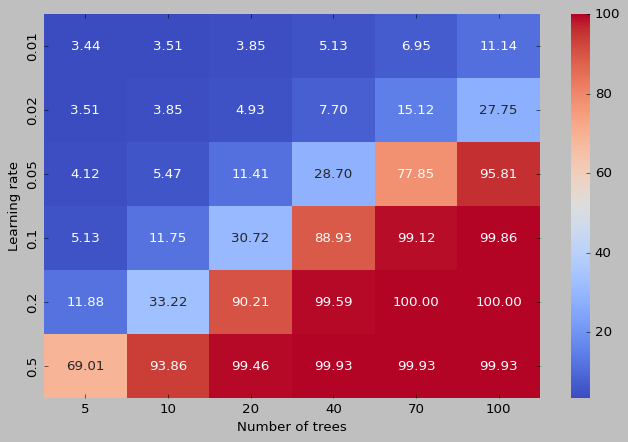

In [115]:
# Generate heatmap, plotting use seaborn
acc_matrix = np.zeros((len(grid_lr), len(grid_tree)))
for i, lr in enumerate(grid_lr):
    for j, nt in enumerate(grid_tree):
        acc_matrix[i, j] = acc[(lr, nt)]

plt.figure(figsize=(10, 6))
sns.heatmap(acc_matrix, annot=True, fmt=".2f", xticklabels=grid_tree, yticklabels=grid_lr, cmap="coolwarm")
plt.xlabel("Number of trees")
plt.ylabel("Learning rate")
# plt.title(f"{parameters}")
plt.savefig("../figure/lgb-grid-search-0.02error.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [215]:
lr, nt = 0.2, 100
# train_data = lgb.Dataset(X_train, label=y_train)
# param = {'objective': 'mean_squared_error', 'boosting': parameters["trainer"], 'learning_rate': lr, 'verbosity': 0, }
# bst = lgb.train(param, train_data, num_boost_round=nt)

bst = lgb.LGBMRegressor(boosting_type=parameters["trainer"], learning_rate=lr, num_boost_round=nt,
                        objective='mean_squared_error', random_state=0)
bst.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_valid, y_valid)], eval_metric='mse')
# bst.booster_.save_model("./models/lgb_orig.txt")


Found `num_boost_round` in params. Will use it instead of argument


[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27893
[LightGBM] [Info] Number of data points in the train set: 8886, number of used features: 191
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Start training from score 4669.855638


LGBMRegressor(learning_rate=0.2, num_boost_round=100,
              objective='mean_squared_error', random_state=0)

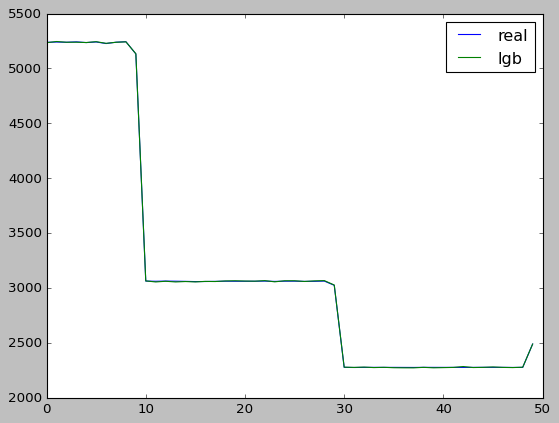

In [117]:
test_num = 50

XXX = list(range(test_num))
YYY_real = y_test[:test_num]
YYY_lgb = bst.predict(X_test[:test_num])

plt.plot(XXX, YYY_real)
plt.plot(XXX, YYY_lgb)
plt.legend(["real", "lgb"])
# plt.ylim(0, 100)
plt.show()

MSE: 17.876292937342786
{0.0: 0.0, 0.0002: 23.02498311951384, 0.0004: 43.07900067521945, 0.0006000000000000001: 58.40648210668468, 0.0008: 70.62795408507765, 0.001: 79.06819716407833, 0.0012000000000000001: 84.87508440243079, 0.0014: 89.12896691424713, 0.0016: 91.42471303173532, 0.0018000000000000002: 93.6529372045915, 0.002: 95.0708980418636, 0.0022: 95.94868332207967, 0.0024000000000000002: 96.89399054692775, 0.0026000000000000003: 97.70425388251182, 0.0028: 98.24442943956785, 0.003: 98.51451721809588, 0.0032: 98.71708305199189, 0.0034000000000000002: 98.85212694125592, 0.0036000000000000003: 99.18973666441595, 0.0038: 99.18973666441595, 0.004: 99.45982444294395, 0.004200000000000001: 99.52734638757596, 0.0044: 99.52734638757596, 0.0046: 99.59486833220797, 0.0048000000000000004: 99.66239027683997, 0.005: 99.79743416610398, 0.005200000000000001: 99.79743416610398, 0.0054: 99.79743416610398, 0.0056: 99.79743416610398, 0.0058000000000000005: 99.79743416610398, 0.006: 99.79743416610398, 

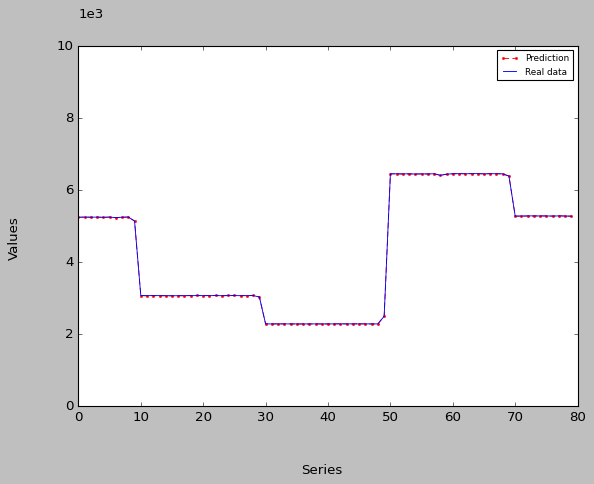

In [216]:
_=evaluation(bst, X_test, y_test, show=True, threshold_list=[0.01 / 50 * i for i in range(51)])

MSE: 17.876292937342786
{0.0: 0.0, 0.0002: 23.02498311951384, 0.0004: 43.07900067521945, 0.0006000000000000001: 58.40648210668468, 0.0008: 70.62795408507765, 0.001: 79.06819716407833, 0.0012000000000000001: 84.87508440243079, 0.0014: 89.12896691424713, 0.0016: 91.42471303173532, 0.0018000000000000002: 93.6529372045915, 0.002: 95.0708980418636, 0.0022: 95.94868332207967, 0.0024000000000000002: 96.89399054692775, 0.0026000000000000003: 97.70425388251182, 0.0028: 98.24442943956785, 0.003: 98.51451721809588, 0.0032: 98.71708305199189, 0.0034000000000000002: 98.85212694125592, 0.0036000000000000003: 99.18973666441595, 0.0038: 99.18973666441595, 0.004: 99.45982444294395, 0.004200000000000001: 99.52734638757596, 0.0044: 99.52734638757596, 0.0046: 99.59486833220797, 0.0048000000000000004: 99.66239027683997, 0.005: 99.79743416610398, 0.005200000000000001: 99.79743416610398, 0.0054: 99.79743416610398, 0.0056: 99.79743416610398, 0.0058000000000000005: 99.79743416610398, 0.006: 99.79743416610398, 

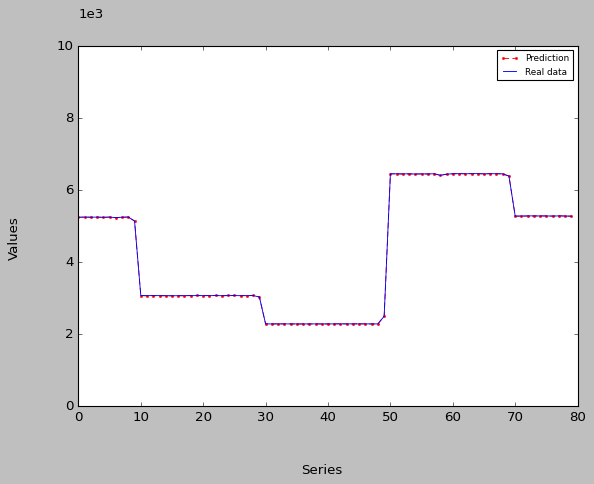

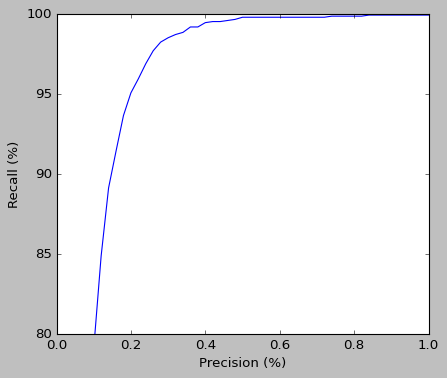

In [148]:
show_acc_plot([evaluation(bst, X_test, y_test, show=True, threshold_list=[0.01 / 50 * i for i in range(51)])], output="../figure/lgb-p-r-curve.pdf")

In [119]:
# plt.rc('font', family='serif')
# plt.rcParams.update({'font.size': 11})
# 
# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['savefig.dpi'] = 300

<Axes: >

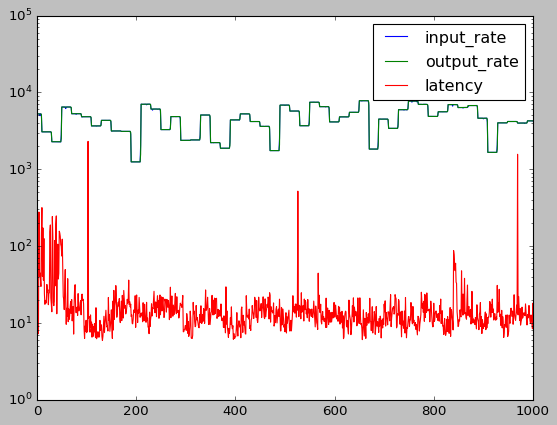

In [120]:
dataset_dt_dropped.reset_index(drop=True).iloc[:, :3].plot(logy=True, xlim=(0, 1000))

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.colors import Normalize
import matplotlib as mp

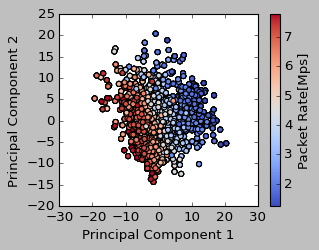

In [122]:

fig, ax = plt.subplots(figsize=(4, 3))
# plt.style.use('classic')

# # Separate the target column from the other columns
# target_col = 'input_rate'
# independent_variables = df.drop(target_col, axis=1)
# dependent_variable = df[target_col].div(1000)

# # Scale the independent variables
# scaler = StandardScaler()
# independent_variables_scaled = scaler.fit_transform(independent_variables)
# print(np.size(independent_variables_scaled))

# Perform PCA
pca = PCA()
pca.n_components = 2
pca.fit(X_train)
independent_variables_pca = pca.transform(X_train)

# # Get unique values in the dependent variable column
# unique_values = y_train.unique()

# Define a colormap based on the unique values
cmap = mp.colormaps.get_cmap('coolwarm')

# Create a scatter plot with colored points
normalize = Normalize(vmin=0, vmax=10)
plt.scatter(independent_variables_pca[:, 0], independent_variables_pca[:, 1],
            c=y_train.div(1000), cmap=cmap)  # , norm=normalize

# Add a color bar to the plot
cbar = plt.colorbar()
cbar.set_label('Packet Rate[Mps]')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# #save figure
# abs_path = os.path.join("..\\dag-1\\figure\\fixed_rate", "dag1_pca_"+ 'load_stimulus_.pdf')
# plt.savefig(abs_path, bbox_inches='tight')

plt.show()


# # Print the eigenvectors and eigenvalues with one decimal place
# print(np.shape(independent_variables_pca))
# a = np.round(pca.components_, 1)
# b=np.round(pca.explained_variance_, 1)
# print("Eigenvectors:\n", np.round(pca.components_, 1))
# print("Eigenvalues:\n", np.round(pca.explained_variance_, 1))


In [123]:
type(bst)


lightgbm.sklearn.LGBMRegressor

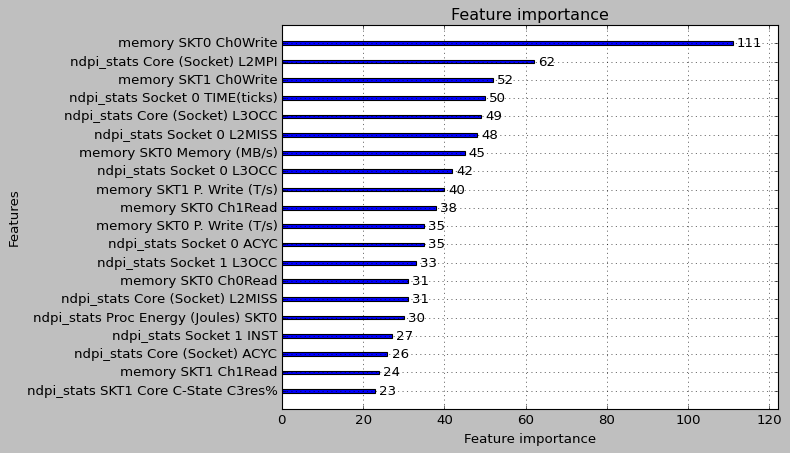

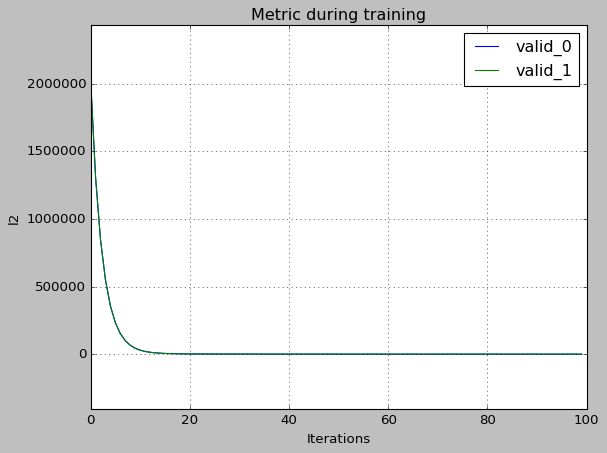

In [225]:
if type(bst) == lgb.sklearn.LGBMRegressor:
    bst.booster_.feature_name = lambda: list(
        dataset_orig_dropped.drop(["input_rate", "output_rate", "latency"], axis=1).columns)
    lgb.plot_importance(bst, max_num_features=20, importance_type="split")
    plt.savefig("../figure/lgb-feature-importance-split.pdf", format="pdf", bbox_inches="tight")
    lgb.plot_metric(bst)

In [226]:
import shap

In [235]:
# even smaller test set for SHAP evaluation
# X_test_smaller, _, y_test_smaller, _ = sklearn.model_selection.train_test_split(X_test, y_test, train_size=500,random_state=0)
X_test_smaller = X_test
y_test_smaller = y_test 

In [236]:
print(len(X_test_smaller))

2000


In [237]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer(X_test)

In [238]:
feature_list = []
for i, name in enumerate(dataset_dt_dropped):
    feature_list.append(name)
    print(i, name)

0 input_rate
1 output_rate
2 latency
3 ndpi_stats Socket 0 EXEC
4 ndpi_stats Socket 0 IPC
5 ndpi_stats Socket 0 FREQ
6 ndpi_stats Socket 0 AFREQ
7 ndpi_stats Socket 0 L3MISS
8 ndpi_stats Socket 0 L2MISS
9 ndpi_stats Socket 0 L3HIT
10 ndpi_stats Socket 0 L2HIT
11 ndpi_stats Socket 0 L2MPI
12 ndpi_stats Socket 0 L3OCC
13 ndpi_stats Socket 0 READ
14 ndpi_stats Socket 0 WRITE
15 ndpi_stats Socket 0 LOCAL
16 ndpi_stats Socket 0 TEMP
17 ndpi_stats Socket 0 INST
18 ndpi_stats Socket 0 ACYC
19 ndpi_stats Socket 0 TIME(ticks)
20 ndpi_stats Socket 0 PhysIPC
21 ndpi_stats Socket 0 PhysIPC%
22 ndpi_stats Socket 0 INSTnom
23 ndpi_stats Socket 0 INSTnom%
24 ndpi_stats Socket 1 EXEC
25 ndpi_stats Socket 1 IPC
26 ndpi_stats Socket 1 FREQ
27 ndpi_stats Socket 1 AFREQ
28 ndpi_stats Socket 1 L3MISS
29 ndpi_stats Socket 1 L2MISS
30 ndpi_stats Socket 1 L3HIT
31 ndpi_stats Socket 1 L2HIT
32 ndpi_stats Socket 1 L3MPI
33 ndpi_stats Socket 1 L2MPI
34 ndpi_stats Socket 1 L3OCC
35 ndpi_stats Socket 1 READ
36 ndp

In [239]:
shap_values.feature_names = feature_list[:len(X_test_smaller[0])]

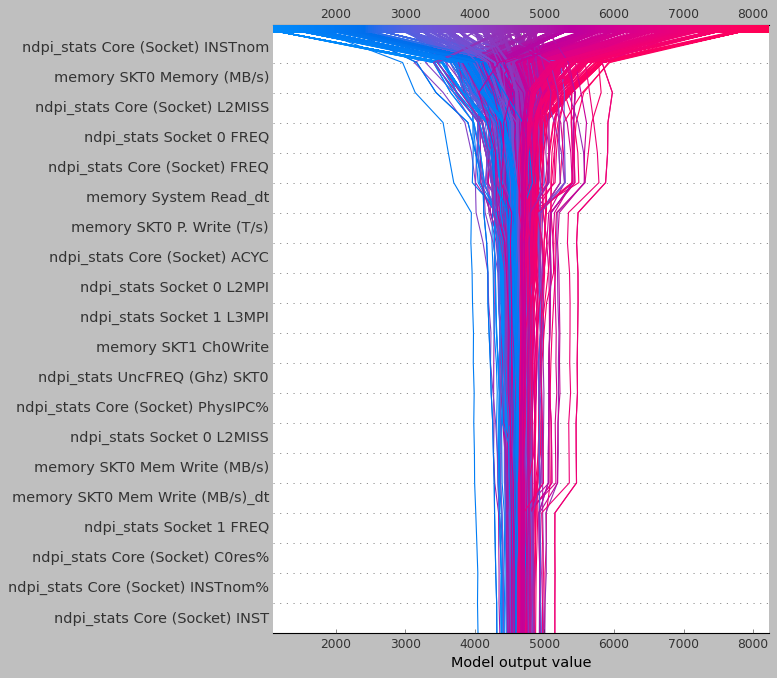

In [243]:
shap.decision_plot(explainer.expected_value, explainer.shap_values(X_test_smaller), shap_values.feature_names, ignore_warnings=True, show=False)
plt.savefig("../figure/lgb-shap-decision-plot.pdf", format="pdf", bbox_inches="tight")

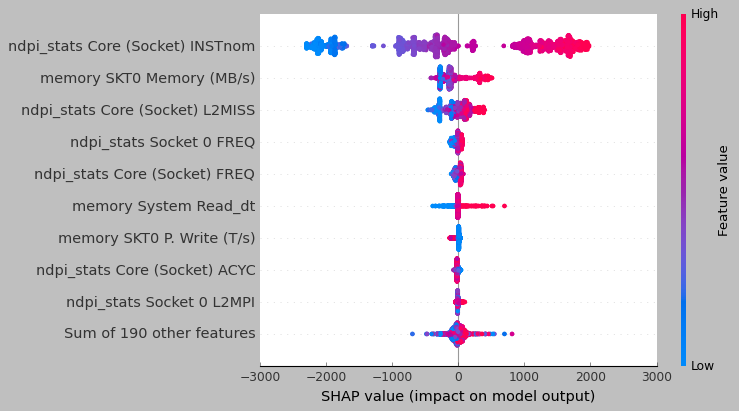

In [244]:
shap.plots.beeswarm(shap_values, show=False)
plt.savefig("../figure/lgb-shap-beeswarm.pdf", format="pdf", bbox_inches="tight")

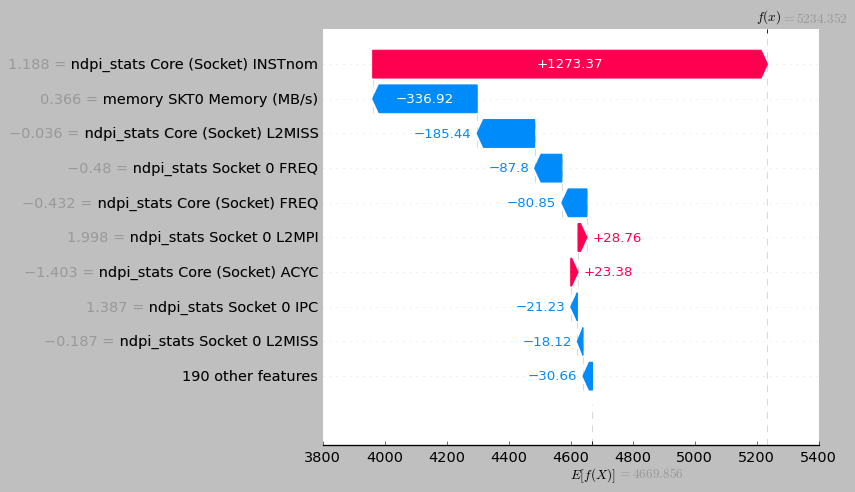

In [133]:
shap.plots.waterfall(shap_values[0], max_display=10)

## ANN

In [149]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


In [204]:
def ann_train(X_train, y_train, validation_data=None):
    with tf.device('/CPU:0'):
        # model
        model = Sequential()

        # Add input layer and hidden layers
        model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(1))

        # 0.01 100
        model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mse'])
        history = model.fit(X_train, y_train, validation_data=validation_data, batch_size=2, epochs=100, verbose=1)

        return model, history

In [205]:
# if not os.path.exists("./models"):
#     os.mkdir("./models")
#     
# if not os.path.exists("./models/ann_orig") or force_train:
#     ann_orig, ann_orig_history = ann_train(X_train_orig, y_train_orig, (X_val_orig[:100], y_val_orig[:100]))
#     ann_orig.save("./models/ann_orig")
# else:
#     ann_orig = tf.keras.models.load_model("./models/ann_orig")

ann, ann_history = ann_train(X_train, y_train, (X_valid[:100], y_valid[:100]))


Epoch 1/100
4443/4443 [==============================] - 5s 961us/step - loss: 13287189.0000 - mse: 13287189.0000 - val_loss: 2515659.2500 - val_mse: 2515659.2500
Epoch 2/100
4443/4443 [==============================] - 4s 913us/step - loss: 2208080.2500 - mse: 2208080.2500 - val_loss: 1131657.8750 - val_mse: 1131657.8750
Epoch 3/100
4443/4443 [==============================] - 4s 921us/step - loss: 1417753.0000 - mse: 1417753.0000 - val_loss: 705947.6875 - val_mse: 705947.6875
Epoch 4/100
4443/4443 [==============================] - 4s 932us/step - loss: 915522.6250 - mse: 915522.6250 - val_loss: 479121.1250 - val_mse: 479121.1250
Epoch 5/100
4443/4443 [==============================] - 4s 928us/step - loss: 561651.5625 - mse: 561651.5625 - val_loss: 361689.0000 - val_mse: 361689.0000
Epoch 6/100
4443/4443 [==============================] - 4s 928us/step - loss: 356554.8750 - mse: 356554.8750 - val_loss: 272272.5000 - val_mse: 272272.5000
Epoch 7/100
4443/4443 [=======================

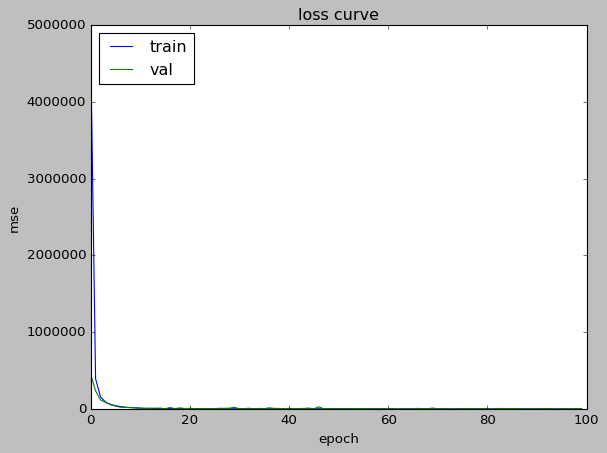

In [201]:
plt.plot(ann_history.history['mse'])
plt.plot(ann_history.history['val_mse'])
plt.title('loss curve')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

93/93 [==============================] - 0s 714us/step
MSE: 227.9455738432125
{0.0: array([0.]), 0.0004: array([12.35651587]), 0.0008: array([23.02498312]), 0.0012000000000000001: array([34.50371371]), 0.0016: array([44.56448346]), 0.002: array([55.03038488]), 0.0024000000000000002: array([63.94328157]), 0.0028: array([70.29034436]), 0.0032: array([75.82714382]), 0.0036000000000000003: array([81.22889939]), 0.004: array([84.74004051]), 0.0044: array([87.71100608]), 0.0048000000000000004: array([89.93923025]), 0.005200000000000001: array([92.16745442]), 0.0056: array([93.45037137]), 0.006: array([94.53072248]), 0.0064: array([95.13841999]), 0.0068000000000000005: array([95.67859554]), 0.007200000000000001: array([96.28629305]), 0.0076: array([96.8264686]), 0.008: array([97.50168805]), 0.008400000000000001: array([97.77177583]), 0.0088: array([97.97434166]), 0.0092: array([98.24442944]), 0.009600000000000001: array([98.51451722]), 0.01: array([98.64956111]), 0.010400000000000001: array([

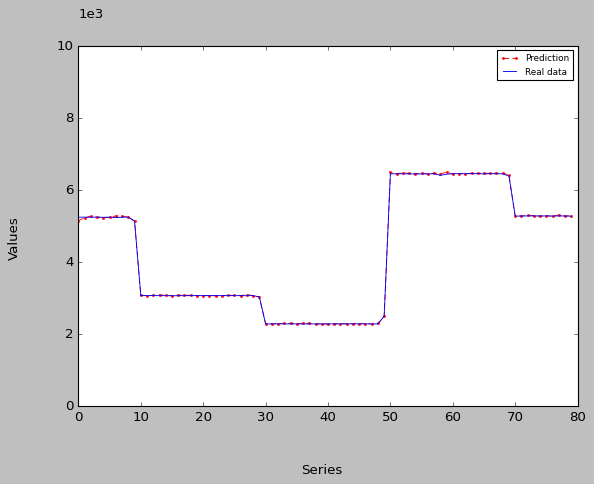

In [218]:
_=evaluation(ann, X_test, y_test, show=True, threshold_list=[0.02 / 50 * i for i in range(51)])

93/93 [==============================] - 0s 723us/step
MSE: 227.9455738432125
{0.0: array([0.]), 0.0004: array([12.35651587]), 0.0008: array([23.02498312]), 0.0012000000000000001: array([34.50371371]), 0.0016: array([44.56448346]), 0.002: array([55.03038488]), 0.0024000000000000002: array([63.94328157]), 0.0028: array([70.29034436]), 0.0032: array([75.82714382]), 0.0036000000000000003: array([81.22889939]), 0.004: array([84.74004051]), 0.0044: array([87.71100608]), 0.0048000000000000004: array([89.93923025]), 0.005200000000000001: array([92.16745442]), 0.0056: array([93.45037137]), 0.006: array([94.53072248]), 0.0064: array([95.13841999]), 0.0068000000000000005: array([95.67859554]), 0.007200000000000001: array([96.28629305]), 0.0076: array([96.8264686]), 0.008: array([97.50168805]), 0.008400000000000001: array([97.77177583]), 0.0088: array([97.97434166]), 0.0092: array([98.24442944]), 0.009600000000000001: array([98.51451722]), 0.01: array([98.64956111]), 0.010400000000000001: array([

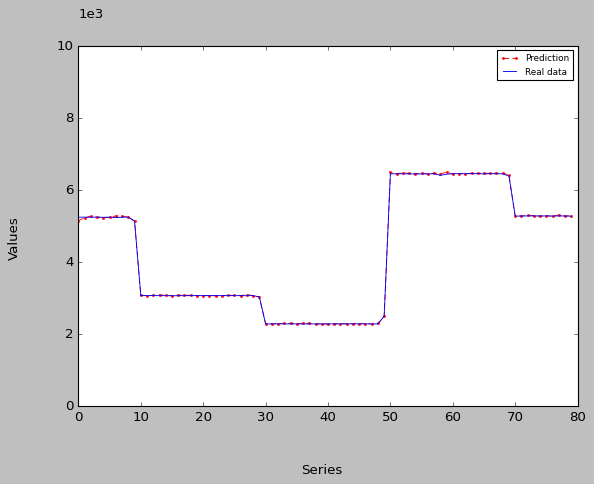

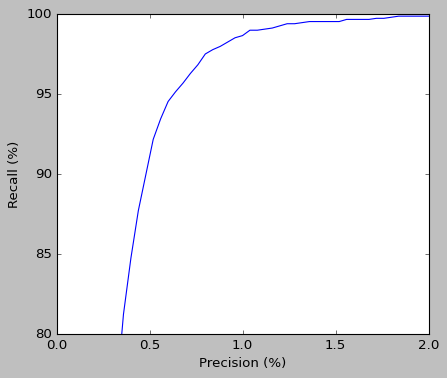

In [207]:
show_acc_plot([evaluation(ann, X_test, y_test, show=True, threshold_list=[0.02 / 50 * i for i in range(51)])], output="../figure/ann-p-r-curve.pdf")